In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import h5py
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
from aux_functions import inverse_normalize,angle_to_2d,is_accurate, plot_metrics, draw_gaze360_arrow
from datasets import MPIIFaceGaze,Gaze360Dataset
from random import randint

In [3]:
from models import GazeEstimation_ResNet18, GazeEstimation_ResNet18Branch, GazeEstimation_MobileNet

# Task

- Predict gaze angle froma picture of the face of an individual.
- Dataset: MPIIFaceGaze. [Link here](https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation).
    - Dataset consists in images of 15 individuals.
    - There are 3000 images per individual. Gaze labels: pitch angle (vertical movement) and yaw angle (horizontal movement).
    - Images were taken from individuals using their laptops during 3 months. 

# 0. Configuration

CUDA

In [4]:
# CUDA configurations
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Device: cuda


# 1. Data analysis

1. Data structure inside the .h5 file.
1. Distribution of angle, using different plots.

- Please place dataset under ./dataset folder

## 1.1. Data structure - qty of images

In [5]:
import scipy.io
# Read dataset and get data
data = scipy.io.loadmat("./datasets/Gaze360/metadata.mat")
recording = data['recording'][0]
print(f"There are {len(recording)} images")

There are 197588 images


In [6]:
import logging
# Set environment variable to suppress logs when using mediapipe
os.environ["GLOG_minloglevel"] = "2"  # 0 = INFO, 1 = WARNING, 2 = ERROR, 3 = FATAL
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # TensorFlow logging level (if used)
os.environ["LIBGL_DEBUG"] = "quiet"
logging.getLogger("mediapipe").setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)  # If Te

In [8]:
%%capture
# Load dataset using class
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=100,random=True,yaw_limits=[-1.1,1.1],face_only=True)

I0000 00:00:1733801089.410873 4153597 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733801089.420550 4156300 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1733801089.423640 4156296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733801089.436522 4156299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733801089.463615 4153597 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733801089.485219 4156305 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1733801089.488313 4156301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single sig

In [ ]:
gaze_list = []
for data in ds:
    gaze = data[1]
    gaze_list.append(gaze)

## 1.2. Angle distribution

Angles are represented using polar coordinates (pitch and yaw). See reference image for more details:

![head_ref.png](head_ref.png)

We are going to analize the data distribution of:

- Pitch: horizontal movement.
- Yaw: vertical movement.
- Angle_2d: Angle proyected to 2D.

In [ ]:
gaze_array = np.array(gaze_list)
pitch_array = gaze_array[:,1]
yaw_array = gaze_array[:,0]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

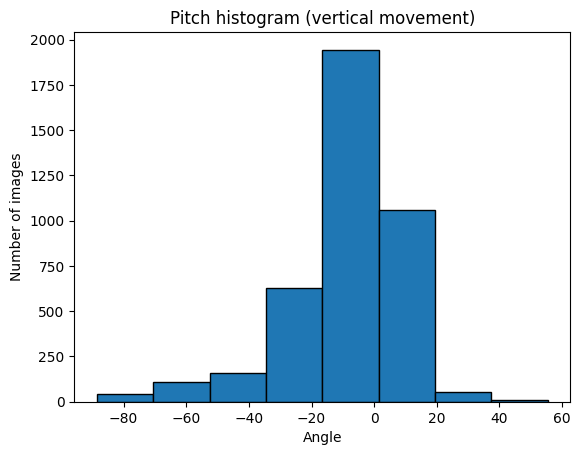

In [ ]:
pitch_array_deg = np.rad2deg(pitch_array)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angle')
plt.ylabel('Number of images')
plt.title('Pitch histogram (vertical movement)')
plt.show()

### 1.2.2 Yaw

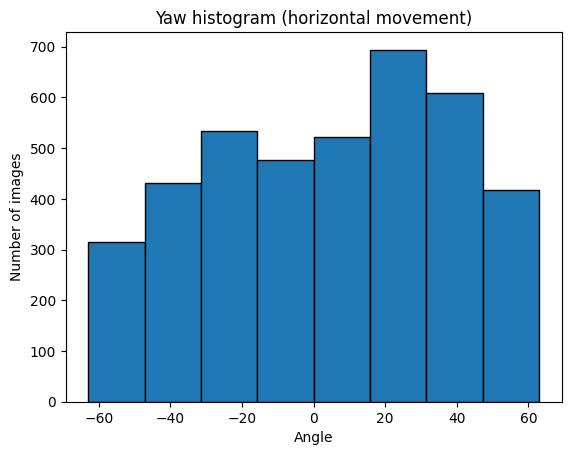

In [ ]:
yaw_array_deg = np.rad2deg(yaw_array)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angle')
plt.ylabel('Number of images')
plt.title('Yaw histogram (horizontal movement)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

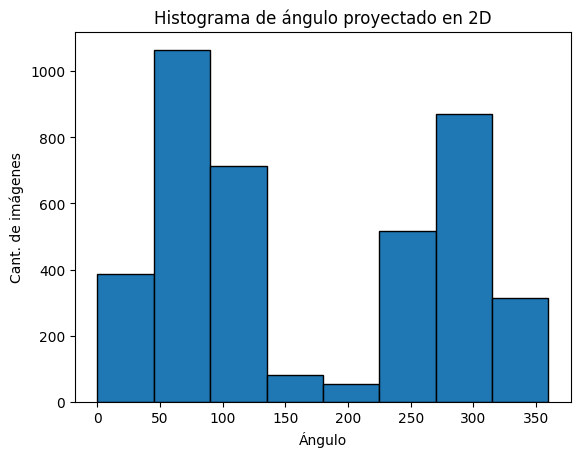

In [ ]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Polar plot de pitch y yaw

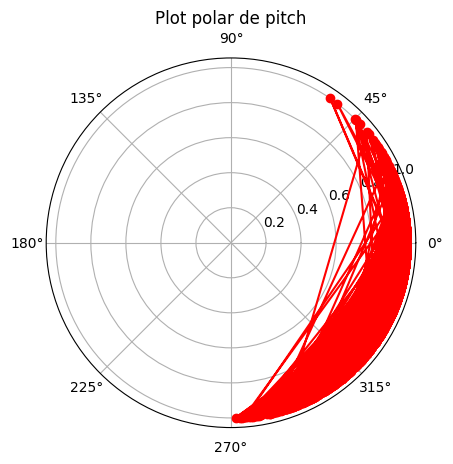

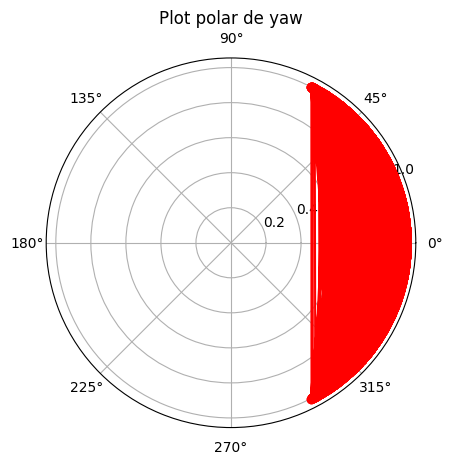

In [ ]:
magnitude_array = np.ones_like(pitch_array)

# Pitch
plt.polar(pitch_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de pitch')
# Show the plot
plt.show()

# Yaw
plt.polar(yaw_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de yaw')
# Show the plot
plt.show()

### 1.2.5 Distribution of pitch and yaw together



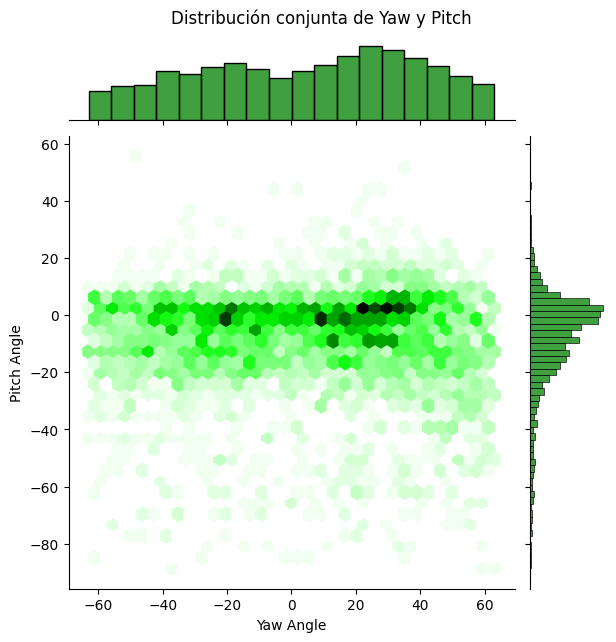

In [ ]:
import seaborn as sns

sns.jointplot(x=yaw_array_deg, y=pitch_array_deg, kind="hex", color="g")
plt.xlabel('Yaw Angle')
plt.ylabel('Pitch Angle')
plt.suptitle('Distribución conjunta de Yaw y Pitch', y=1.03)
plt.show()

## 2. Dataset preparation

- To make things easier we create a class inherited for torch.utils.Dataset. Asociated code is inside _datasets.py_

## 2.1 Data augmentation

- Image are resized to 224x224 to use pre-trained models (most are pre-trained on imagenet).
- Data augmentation:
    - RandomResizedCrop: Crop and zoom images randomly.
    - ColorJitter: Slight changes on hue and saturation to take into account light changes.
    - HorizontalFlip or VerticalFlip can't be used because they alter eye gaze.

In [7]:
WIDTH = 90 
HEIGHT = 90

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.05,0.15)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    # torchvision.transforms.RandomErasing(p=0.1,scale=(0.02,0.08),ratio=(1,1.7),value="random"),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.15),
    # torchvision.transforms.Normalize(mean=[0.2740, 0.2626, 0.2639],std=[0.1757, 0.1787, 0.1761]),
])


In [8]:
%%capture
# Ahora sí cargamos todas las imágenes que se van a utilizar en el entrenamiento
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=1000,random=True,transform=data_transforms,yaw_limits=[-1.1,1.1],face_only=True)
print(f"{len(ds)} images were loaded")

libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI3: Screen seems not DRI3 capable
I0000 00:00:1734210150.057102  502866 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734210150.071162  504908 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1734210150.121132  504885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734210150.140652  504882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734210150.146662  504885 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
I0000 00:00:1

## 2.2 Train and test datasets

In [9]:
# (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)


Shapes: torch.Size([24, 3, 90, 90]) torch.Size([24, 2])
pitch yaw: tensor([ 0.9017, -0.8892], dtype=torch.float64)


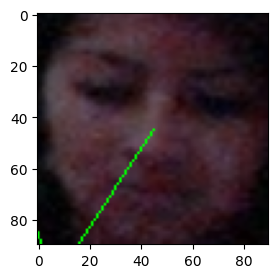

In [10]:
# Visualize a sample
train_image, train_labels = next(iter(train_loader))

print("Shapes:",train_image.shape, train_labels.shape)

# Plot with annotations over it
ii = 0
img = train_image[ii]
# img = inverse_normalize(img,mean=torch.tensor([0.2740, 0.2626, 0.2639]),std=torch.tensor([0.1757, 0.1787, 0.1761]))
img = img.permute(1, 2, 0)
img = (img.numpy()*255).astype(np.uint8)
lbl = train_labels[ii]
height,width,_ = img.shape
img_annotated = draw_gaze360_arrow(img,lbl,[int(width/2),int(height/2)],scale=80)
plt.figure(figsize=(3,3))
plt.imshow(img_annotated)
print(f'pitch yaw: {lbl}')

Aux: Calculate mean and std of this dataset

In [24]:
# Variables to store the sums
mean = 0.
std = 0.
n_samples = 0.

for images, _ in val_loader:
    batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
    images = images.view(batch_samples, images.size(1), -1)  # flatten image channels
    mean += images.mean(2).sum(0)  # sum across batch and spatial dimensions
    std += images.std(2).sum(0)
    n_samples += batch_samples

# Final mean and std
mean /= n_samples
std /= n_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

# Mean: tensor([0.2695, 0.2611, 0.2635])
# Std: tensor([0.1749, 0.1787, 0.1769])

Mean: tensor([0.3058, 0.2605, 0.2465])
Std: tensor([0.0990, 0.0926, 0.0879])


# 3. Models

We are going to test these models:

- Model based on ResNet18:
    - Using transfer learning
    - Parameters of first layers are freezed.
    - Two fully connected layers added at the end
      
- Model based on MobileNetV2:
    - Same procedure as in resnet case
      
      

## 3.4 Model based on MobileNet

### 3.4.1 Instantiation

In [ ]:
# Instantiate and configure model
model_mobilenet = GazeEstimation_MobileNet(name="gaze360/mobilenet__epochs_100__lr_1Em3__filtered__face",pretrained=True, debug=False) #Debug=True show trainable layers
model_mobilenet.dynamic_lr = True
model_mobilenet.minimum_lr = 1e-6
model_mobilenet.lr_adjustment_ratio = 0.3
model_mobilenet.lr_epochs_adjustment = 60 # Reduce learning rate by 0.3 every 40 epochs

# MSELoss for regression problem
criterion = nn.MSELoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model_mobilenet.parameters(), lr=1e-3)

#Summary
summary(model_mobilenet.to(device), input_size=(3, 90, 90))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 45, 45]             864
       BatchNorm2d-2           [-1, 32, 45, 45]              64
             ReLU6-3           [-1, 32, 45, 45]               0
            Conv2d-4           [-1, 32, 45, 45]             288
       BatchNorm2d-5           [-1, 32, 45, 45]              64
             ReLU6-6           [-1, 32, 45, 45]               0
            Conv2d-7           [-1, 16, 45, 45]             512
       BatchNorm2d-8           [-1, 16, 45, 45]              32
  InvertedResidual-9           [-1, 16, 45, 45]               0
           Conv2d-10           [-1, 96, 45, 45]           1,536
      BatchNorm2d-11           [-1, 96, 45, 45]             192
            ReLU6-12           [-1, 96, 45, 45]               0
           Conv2d-13           [-1, 96, 23, 23]             864
      BatchNorm2d-14           [-1, 96,

### 3.4.2 Training

In [136]:
model_mobilenet.fit(train_loader, val_loader, criterion, optimizer, epochs=300, device=device, save_model=True)

Epoch 1/300


Validation loss 0.10011: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.1622 / 26.63% | Validation Loss / Accuracy: 0.1001 / 43.23%
Epoch 2/300


Validation loss 0.08004: 100%|██████████| 125/125 [00:18<00:00,  6.82it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0931 / 46.28% | Validation Loss / Accuracy: 0.0800 / 49.97%
Epoch 3/300


Validation loss 0.07135: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0813 / 50.62% | Validation Loss / Accuracy: 0.0713 / 53.23%
Epoch 4/300


Validation loss 0.06813: 100%|██████████| 125/125 [00:18<00:00,  6.75it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0701 / 52.99% | Validation Loss / Accuracy: 0.0681 / 55.90%
Epoch 5/300


Validation loss 0.06481: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0654 / 55.24% | Validation Loss / Accuracy: 0.0648 / 56.40%
Epoch 6/300


Validation loss 0.06137: 100%|██████████| 125/125 [00:18<00:00,  6.67it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0587 / 57.15% | Validation Loss / Accuracy: 0.0614 / 57.73%
Epoch 7/300


Validation loss 0.05888: 100%|██████████| 125/125 [00:18<00:00,  6.68it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0544 / 59.00% | Validation Loss / Accuracy: 0.0589 / 58.83%
Epoch 8/300


Validation loss 0.05721: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0487 / 61.40% | Validation Loss / Accuracy: 0.0572 / 61.37%
Epoch 9/300


Validation loss 0.05765: 100%|██████████| 125/125 [00:18<00:00,  6.82it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0453 / 61.62% | Validation Loss / Accuracy: 0.0576 / 59.30%
Epoch 10/300


Validation loss 0.05491: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0413 / 62.73% | Validation Loss / Accuracy: 0.0549 / 61.50%
Epoch 11/300


Validation loss 0.05563: 100%|██████████| 125/125 [00:18<00:00,  6.72it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0383 / 64.78% | Validation Loss / Accuracy: 0.0556 / 61.13%
Epoch 12/300


Validation loss 0.05305: 100%|██████████| 125/125 [00:18<00:00,  6.81it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0351 / 66.85% | Validation Loss / Accuracy: 0.0530 / 61.23%
Epoch 13/300


Validation loss 0.05327: 100%|██████████| 125/125 [00:18<00:00,  6.71it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0326 / 67.39% | Validation Loss / Accuracy: 0.0533 / 61.90%
Epoch 14/300


Validation loss 0.05179: 100%|██████████| 125/125 [00:18<00:00,  6.68it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0313 / 68.71% | Validation Loss / Accuracy: 0.0518 / 61.80%
Epoch 15/300


Validation loss 0.05043: 100%|██████████| 125/125 [00:18<00:00,  6.67it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0292 / 69.85% | Validation Loss / Accuracy: 0.0504 / 61.73%
Epoch 16/300


Validation loss 0.05211: 100%|██████████| 125/125 [00:18<00:00,  6.82it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0275 / 70.03% | Validation Loss / Accuracy: 0.0521 / 62.57%
Epoch 17/300


Validation loss 0.05068: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0260 / 71.09% | Validation Loss / Accuracy: 0.0507 / 62.37%
Epoch 18/300


Validation loss 0.05024: 100%|██████████| 125/125 [00:18<00:00,  6.72it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0245 / 72.67% | Validation Loss / Accuracy: 0.0502 / 63.97%
Epoch 19/300


Validation loss 0.04929: 100%|██████████| 125/125 [00:18<00:00,  6.71it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0230 / 73.60% | Validation Loss / Accuracy: 0.0493 / 63.60%
Epoch 20/300


Validation loss 0.04803: 100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0216 / 74.81% | Validation Loss / Accuracy: 0.0480 / 64.83%
Epoch 21/300


Validation loss 0.04692: 100%|██████████| 125/125 [00:18<00:00,  6.77it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0207 / 75.89% | Validation Loss / Accuracy: 0.0469 / 65.53%
Epoch 22/300


Validation loss 0.04670: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0197 / 76.08% | Validation Loss / Accuracy: 0.0467 / 64.33%
Epoch 23/300


Validation loss 0.04653: 100%|██████████| 125/125 [00:18<00:00,  6.69it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0188 / 76.36% | Validation Loss / Accuracy: 0.0465 / 66.10%
Epoch 24/300


Validation loss 0.04588: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0181 / 76.92% | Validation Loss / Accuracy: 0.0459 / 65.77%
Epoch 25/300


Validation loss 0.04503: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0170 / 78.43% | Validation Loss / Accuracy: 0.0450 / 65.60%
Epoch 26/300


Validation loss 0.04610: 100%|██████████| 125/125 [00:18<00:00,  6.64it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0161 / 79.00% | Validation Loss / Accuracy: 0.0461 / 66.17%
Epoch 27/300


Validation loss 0.04577: 100%|██████████| 125/125 [00:18<00:00,  6.77it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0158 / 79.11% | Validation Loss / Accuracy: 0.0458 / 66.80%
Epoch 28/300


Validation loss 0.04450: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0157 / 79.86% | Validation Loss / Accuracy: 0.0445 / 66.50%
Epoch 29/300


Validation loss 0.04453: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0149 / 81.02% | Validation Loss / Accuracy: 0.0445 / 67.83%
Epoch 30/300


Validation loss 0.04298: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0138 / 81.78% | Validation Loss / Accuracy: 0.0430 / 65.90%
Epoch 31/300


Validation loss 0.04233: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0137 / 81.76% | Validation Loss / Accuracy: 0.0423 / 67.83%
Epoch 32/300


Validation loss 0.04328: 100%|██████████| 125/125 [00:18<00:00,  6.67it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0130 / 82.37% | Validation Loss / Accuracy: 0.0433 / 68.07%
Epoch 33/300


Validation loss 0.04319: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0132 / 82.21% | Validation Loss / Accuracy: 0.0432 / 66.83%
Epoch 34/300


Validation loss 0.04174: 100%|██████████| 125/125 [00:18<00:00,  6.65it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0123 / 83.22% | Validation Loss / Accuracy: 0.0417 / 68.13%
Epoch 35/300


Validation loss 0.04206: 100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0126 / 82.38% | Validation Loss / Accuracy: 0.0421 / 68.10%
Epoch 36/300


Validation loss 0.04292: 100%|██████████| 125/125 [00:18<00:00,  6.64it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0118 / 83.48% | Validation Loss / Accuracy: 0.0429 / 68.03%
Epoch 37/300


Validation loss 0.04089: 100%|██████████| 125/125 [00:18<00:00,  6.65it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0114 / 84.29% | Validation Loss / Accuracy: 0.0409 / 68.40%
Epoch 38/300


Validation loss 0.04058: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0112 / 84.62% | Validation Loss / Accuracy: 0.0406 / 67.93%
Epoch 39/300


Validation loss 0.04059: 100%|██████████| 125/125 [00:18<00:00,  6.69it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0103 / 85.36% | Validation Loss / Accuracy: 0.0406 / 69.17%
Epoch 40/300


Validation loss 0.04057: 100%|██████████| 125/125 [00:19<00:00,  6.57it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0105 / 85.14% | Validation Loss / Accuracy: 0.0406 / 68.87%
Epoch 41/300


Validation loss 0.04077: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0105 / 85.89% | Validation Loss / Accuracy: 0.0408 / 69.10%
Epoch 42/300


Validation loss 0.04046: 100%|██████████| 125/125 [00:18<00:00,  6.71it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0097 / 86.47% | Validation Loss / Accuracy: 0.0405 / 68.30%
Epoch 43/300


Validation loss 0.04007: 100%|██████████| 125/125 [00:18<00:00,  6.64it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0095 / 85.74% | Validation Loss / Accuracy: 0.0401 / 68.73%
Epoch 44/300


Validation loss 0.04022: 100%|██████████| 125/125 [00:19<00:00,  6.57it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0097 / 86.48% | Validation Loss / Accuracy: 0.0402 / 67.93%
Epoch 45/300


Validation loss 0.03968: 100%|██████████| 125/125 [00:18<00:00,  6.61it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0089 / 87.06% | Validation Loss / Accuracy: 0.0397 / 70.03%
Epoch 46/300


Validation loss 0.03962: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0089 / 86.91% | Validation Loss / Accuracy: 0.0396 / 69.13%
Epoch 47/300


Validation loss 0.03941: 100%|██████████| 125/125 [00:18<00:00,  6.62it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0088 / 87.49% | Validation Loss / Accuracy: 0.0394 / 70.23%
Epoch 48/300


Validation loss 0.03945: 100%|██████████| 125/125 [00:19<00:00,  6.58it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0084 / 88.27% | Validation Loss / Accuracy: 0.0395 / 69.40%
Epoch 49/300


Validation loss 0.03862: 100%|██████████| 125/125 [00:18<00:00,  6.64it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0082 / 88.09% | Validation Loss / Accuracy: 0.0386 / 70.87%
Epoch 50/300


Validation loss 0.03892: 100%|██████████| 125/125 [00:18<00:00,  6.66it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0079 / 88.47% | Validation Loss / Accuracy: 0.0389 / 70.13%
Epoch 51/300


Validation loss 0.03888: 100%|██████████| 125/125 [00:18<00:00,  6.78it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0078 / 88.79% | Validation Loss / Accuracy: 0.0389 / 70.00%
Epoch 52/300


Validation loss 0.03792: 100%|██████████| 125/125 [00:18<00:00,  6.67it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0080 / 88.27% | Validation Loss / Accuracy: 0.0379 / 70.10%
Epoch 53/300


Validation loss 0.03792: 100%|██████████| 125/125 [00:18<00:00,  6.67it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0078 / 88.64% | Validation Loss / Accuracy: 0.0379 / 70.50%
Epoch 54/300


Validation loss 0.03783: 100%|██████████| 125/125 [00:18<00:00,  6.77it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0075 / 89.33% | Validation Loss / Accuracy: 0.0378 / 70.13%
Epoch 55/300


Validation loss 0.03770: 100%|██████████| 125/125 [00:18<00:00,  6.69it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0074 / 89.33% | Validation Loss / Accuracy: 0.0377 / 70.63%
Epoch 56/300


Validation loss 0.03839: 100%|██████████| 125/125 [00:18<00:00,  6.75it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0071 / 89.63% | Validation Loss / Accuracy: 0.0384 / 70.17%
Epoch 57/300


Validation loss 0.03871: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0073 / 89.66% | Validation Loss / Accuracy: 0.0387 / 70.83%
Epoch 58/300


Validation loss 0.03743: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0071 / 89.63% | Validation Loss / Accuracy: 0.0374 / 71.17%
Epoch 59/300


Validation loss 0.03771: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0068 / 89.70% | Validation Loss / Accuracy: 0.0377 / 70.90%
Epoch 60/300


Validation loss 0.03652: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.5e-05] Training Loss / Accuracy: 0.0063 / 90.82% | Validation Loss / Accuracy: 0.0365 / 71.10%
Epoch 61/300


Validation loss 0.03688: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0061 / 91.05% | Validation Loss / Accuracy: 0.0369 / 71.50%
Epoch 62/300


Validation loss 0.03673: 100%|██████████| 125/125 [00:18<00:00,  6.81it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0058 / 90.87% | Validation Loss / Accuracy: 0.0367 / 71.13%
Epoch 63/300


Validation loss 0.03665: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0056 / 91.25% | Validation Loss / Accuracy: 0.0367 / 71.20%
Epoch 64/300


Validation loss 0.03654: 100%|██████████| 125/125 [00:18<00:00,  6.73it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0053 / 92.04% | Validation Loss / Accuracy: 0.0365 / 71.50%
Epoch 65/300


Validation loss 0.03659: 100%|██████████| 125/125 [00:18<00:00,  6.61it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0055 / 91.68% | Validation Loss / Accuracy: 0.0366 / 71.40%
Epoch 66/300


Validation loss 0.03647: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.5e-05] Training Loss / Accuracy: 0.0055 / 91.41% | Validation Loss / Accuracy: 0.0365 / 71.73%
Epoch 67/300


Validation loss 0.03602: 100%|██████████| 125/125 [00:18<00:00,  6.71it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.5e-05] Training Loss / Accuracy: 0.0055 / 91.67% | Validation Loss / Accuracy: 0.0360 / 71.93%
Epoch 68/300


Validation loss 0.03694: 100%|██████████| 125/125 [00:18<00:00,  6.77it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0054 / 91.20% | Validation Loss / Accuracy: 0.0369 / 71.03%
Epoch 69/300


Validation loss 0.03686: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0054 / 91.55% | Validation Loss / Accuracy: 0.0369 / 71.53%
Epoch 70/300


Validation loss 0.03712: 100%|██████████| 125/125 [00:19<00:00,  6.42it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0051 / 91.90% | Validation Loss / Accuracy: 0.0371 / 70.83%
Epoch 71/300


Validation loss 0.03650: 100%|██████████| 125/125 [00:21<00:00,  5.93it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0052 / 91.77% | Validation Loss / Accuracy: 0.0365 / 71.27%
Epoch 72/300


Validation loss 0.03674: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0051 / 91.59% | Validation Loss / Accuracy: 0.0367 / 72.20%
Epoch 73/300


Validation loss 0.03702: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0051 / 91.97% | Validation Loss / Accuracy: 0.0370 / 71.67%
Epoch 74/300


Validation loss 0.03620: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0051 / 91.86% | Validation Loss / Accuracy: 0.0362 / 71.70%
Epoch 75/300


Validation loss 0.03665: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0049 / 92.15% | Validation Loss / Accuracy: 0.0366 / 72.07%
Epoch 76/300


Validation loss 0.03587: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.5e-05] Training Loss / Accuracy: 0.0051 / 91.47% | Validation Loss / Accuracy: 0.0359 / 72.00%
Epoch 77/300


Validation loss 0.03622: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0050 / 91.48% | Validation Loss / Accuracy: 0.0362 / 71.83%
Epoch 78/300


Validation loss 0.03627: 100%|██████████| 125/125 [00:18<00:00,  6.62it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0051 / 91.98% | Validation Loss / Accuracy: 0.0363 / 72.17%
Epoch 79/300


Validation loss 0.03538: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.5e-05] Training Loss / Accuracy: 0.0050 / 92.04% | Validation Loss / Accuracy: 0.0354 / 72.67%
Epoch 80/300


Validation loss 0.03659: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0048 / 92.09% | Validation Loss / Accuracy: 0.0366 / 72.17%
Epoch 81/300


Validation loss 0.03599: 100%|██████████| 125/125 [00:18<00:00,  6.61it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0049 / 92.09% | Validation Loss / Accuracy: 0.0360 / 71.77%
Epoch 82/300


Validation loss 0.03648: 100%|██████████| 125/125 [00:18<00:00,  6.61it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0047 / 91.98% | Validation Loss / Accuracy: 0.0365 / 71.70%
Epoch 83/300


Validation loss 0.03586: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0047 / 91.95% | Validation Loss / Accuracy: 0.0359 / 71.50%
Epoch 84/300


Validation loss 0.03517: 100%|██████████| 125/125 [00:18<00:00,  6.63it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.5e-05] Training Loss / Accuracy: 0.0047 / 92.53% | Validation Loss / Accuracy: 0.0352 / 72.20%
Epoch 85/300


Validation loss 0.03656: 100%|██████████| 125/125 [00:19<00:00,  6.55it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0047 / 92.55% | Validation Loss / Accuracy: 0.0366 / 71.03%
Epoch 86/300


Validation loss 0.03554: 100%|██████████| 125/125 [00:19<00:00,  6.53it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0047 / 92.13% | Validation Loss / Accuracy: 0.0355 / 71.83%
Epoch 87/300


Validation loss 0.03602: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0047 / 92.59% | Validation Loss / Accuracy: 0.0360 / 71.63%
Epoch 88/300


Validation loss 0.03556: 100%|██████████| 125/125 [00:18<00:00,  6.65it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0047 / 92.88% | Validation Loss / Accuracy: 0.0356 / 71.87%
Epoch 89/300


Validation loss 0.03579: 100%|██████████| 125/125 [00:18<00:00,  6.59it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0045 / 92.60% | Validation Loss / Accuracy: 0.0358 / 71.80%
Epoch 90/300


Validation loss 0.03570: 100%|██████████| 125/125 [00:18<00:00,  6.62it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0046 / 92.05% | Validation Loss / Accuracy: 0.0357 / 72.73%
Epoch 91/300


Validation loss 0.03595: 100%|██████████| 125/125 [00:19<00:00,  6.53it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0045 / 92.88% | Validation Loss / Accuracy: 0.0359 / 72.13%
Epoch 92/300


Validation loss 0.03561: 100%|██████████| 125/125 [00:19<00:00,  6.56it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0045 / 92.97% | Validation Loss / Accuracy: 0.0356 / 72.60%
Epoch 93/300


Validation loss 0.03571: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0043 / 92.74% | Validation Loss / Accuracy: 0.0357 / 72.23%
Epoch 94/300


Validation loss 0.03582: 100%|██████████| 125/125 [00:19<00:00,  6.42it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0043 / 93.01% | Validation Loss / Accuracy: 0.0358 / 73.07%
Epoch 95/300


Validation loss 0.03559: 100%|██████████| 125/125 [00:19<00:00,  6.47it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0044 / 92.38% | Validation Loss / Accuracy: 0.0356 / 72.10%
Epoch 96/300


Validation loss 0.03587: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0044 / 92.93% | Validation Loss / Accuracy: 0.0359 / 71.87%
Epoch 97/300


Validation loss 0.03548: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0043 / 93.08% | Validation Loss / Accuracy: 0.0355 / 72.97%
Epoch 98/300


Validation loss 0.03537: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0043 / 93.40% | Validation Loss / Accuracy: 0.0354 / 72.53%
Epoch 99/300


Validation loss 0.03533: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0043 / 92.87% | Validation Loss / Accuracy: 0.0353 / 72.93%
Epoch 100/300


Validation loss 0.03462: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.5e-05] Training Loss / Accuracy: 0.0041 / 93.24% | Validation Loss / Accuracy: 0.0346 / 72.60%
Epoch 101/300


Validation loss 0.03578: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0042 / 93.29% | Validation Loss / Accuracy: 0.0358 / 72.67%
Epoch 102/300


Validation loss 0.03537: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0042 / 92.82% | Validation Loss / Accuracy: 0.0354 / 72.63%
Epoch 103/300


Validation loss 0.03555: 100%|██████████| 125/125 [00:19<00:00,  6.45it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0043 / 93.32% | Validation Loss / Accuracy: 0.0355 / 73.20%
Epoch 104/300


Validation loss 0.03544: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0043 / 92.79% | Validation Loss / Accuracy: 0.0354 / 72.80%
Epoch 105/300


Validation loss 0.03571: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0042 / 93.00% | Validation Loss / Accuracy: 0.0357 / 72.43%
Epoch 106/300


Validation loss 0.03552: 100%|██████████| 125/125 [00:19<00:00,  6.47it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0041 / 93.19% | Validation Loss / Accuracy: 0.0355 / 72.53%
Epoch 107/300


Validation loss 0.03602: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0040 / 93.14% | Validation Loss / Accuracy: 0.0360 / 72.53%
Epoch 108/300


Validation loss 0.03579: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0041 / 93.24% | Validation Loss / Accuracy: 0.0358 / 72.37%
Epoch 109/300


Validation loss 0.03513: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0042 / 93.74% | Validation Loss / Accuracy: 0.0351 / 72.57%
Epoch 110/300


Validation loss 0.03537: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0041 / 93.28% | Validation Loss / Accuracy: 0.0354 / 72.87%
Epoch 111/300


Validation loss 0.03541: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0041 / 93.52% | Validation Loss / Accuracy: 0.0354 / 73.23%
Epoch 112/300


Validation loss 0.03503: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0040 / 93.33% | Validation Loss / Accuracy: 0.0350 / 72.80%
Epoch 113/300


Validation loss 0.03523: 100%|██████████| 125/125 [00:19<00:00,  6.45it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0040 / 93.74% | Validation Loss / Accuracy: 0.0352 / 72.67%
Epoch 114/300


Validation loss 0.03598: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0041 / 92.97% | Validation Loss / Accuracy: 0.0360 / 72.57%
Epoch 115/300


Validation loss 0.03483: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0040 / 93.51% | Validation Loss / Accuracy: 0.0348 / 73.07%
Epoch 116/300


Validation loss 0.03531: 100%|██████████| 125/125 [00:19<00:00,  6.42it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0040 / 93.81% | Validation Loss / Accuracy: 0.0353 / 73.23%
Epoch 117/300


Validation loss 0.03495: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0038 / 93.96% | Validation Loss / Accuracy: 0.0349 / 72.80%
Epoch 118/300


Validation loss 0.03557: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0038 / 93.71% | Validation Loss / Accuracy: 0.0356 / 73.00%
Epoch 119/300


Validation loss 0.03577: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


[Lr:1.5e-05] Training Loss / Accuracy: 0.0040 / 93.70% | Validation Loss / Accuracy: 0.0358 / 72.93%
Epoch 120/300


Validation loss 0.03564: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0037 / 93.86% | Validation Loss / Accuracy: 0.0356 / 72.23%
Epoch 121/300


Validation loss 0.03517: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0037 / 93.79% | Validation Loss / Accuracy: 0.0352 / 73.13%
Epoch 122/300


Validation loss 0.03554: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0038 / 93.55% | Validation Loss / Accuracy: 0.0355 / 72.40%
Epoch 123/300


Validation loss 0.03518: 100%|██████████| 125/125 [00:19<00:00,  6.57it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.53% | Validation Loss / Accuracy: 0.0352 / 72.77%
Epoch 124/300


Validation loss 0.03513: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0037 / 94.24% | Validation Loss / Accuracy: 0.0351 / 72.97%
Epoch 125/300


Validation loss 0.03500: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.49% | Validation Loss / Accuracy: 0.0350 / 73.40%
Epoch 126/300


Validation loss 0.03493: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.14% | Validation Loss / Accuracy: 0.0349 / 72.83%
Epoch 127/300


Validation loss 0.03497: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0037 / 94.31% | Validation Loss / Accuracy: 0.0350 / 72.77%
Epoch 128/300


Validation loss 0.03629: 100%|██████████| 125/125 [00:19<00:00,  6.40it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.06% | Validation Loss / Accuracy: 0.0363 / 71.77%
Epoch 129/300


Validation loss 0.03521: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0037 / 94.12% | Validation Loss / Accuracy: 0.0352 / 73.00%
Epoch 130/300


Validation loss 0.03501: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0037 / 93.72% | Validation Loss / Accuracy: 0.0350 / 73.50%
Epoch 131/300


Validation loss 0.03495: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.28% | Validation Loss / Accuracy: 0.0350 / 73.50%
Epoch 132/300


Validation loss 0.03461: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.02% | Validation Loss / Accuracy: 0.0346 / 72.77%
Epoch 133/300


Validation loss 0.03512: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.24% | Validation Loss / Accuracy: 0.0351 / 73.10%
Epoch 134/300


Validation loss 0.03526: 100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 93.99% | Validation Loss / Accuracy: 0.0353 / 73.10%
Epoch 135/300


Validation loss 0.03501: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.01% | Validation Loss / Accuracy: 0.0350 / 72.27%
Epoch 136/300


Validation loss 0.03501: 100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.18% | Validation Loss / Accuracy: 0.0350 / 72.57%
Epoch 137/300


Validation loss 0.03566: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.46% | Validation Loss / Accuracy: 0.0357 / 72.40%
Epoch 138/300


Validation loss 0.03533: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0036 / 94.41% | Validation Loss / Accuracy: 0.0353 / 73.07%
Epoch 139/300


Validation loss 0.03517: 100%|██████████| 125/125 [00:19<00:00,  6.40it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.23% | Validation Loss / Accuracy: 0.0352 / 73.30%
Epoch 140/300


Validation loss 0.03452: 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 93.94% | Validation Loss / Accuracy: 0.0345 / 72.47%
Epoch 141/300


Validation loss 0.03503: 100%|██████████| 125/125 [00:19<00:00,  6.47it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.39% | Validation Loss / Accuracy: 0.0350 / 72.67%
Epoch 142/300


Validation loss 0.03528: 100%|██████████| 125/125 [00:19<00:00,  6.45it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.31% | Validation Loss / Accuracy: 0.0353 / 73.03%
Epoch 143/300


Validation loss 0.03501: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.16% | Validation Loss / Accuracy: 0.0350 / 73.87%
Epoch 144/300


Validation loss 0.03491: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 93.75% | Validation Loss / Accuracy: 0.0349 / 73.40%
Epoch 145/300


Validation loss 0.03490: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.40% | Validation Loss / Accuracy: 0.0349 / 72.70%
Epoch 146/300


Validation loss 0.03514: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.14% | Validation Loss / Accuracy: 0.0351 / 73.53%
Epoch 147/300


Validation loss 0.03494: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.21% | Validation Loss / Accuracy: 0.0349 / 73.33%
Epoch 148/300


Validation loss 0.03518: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 93.96% | Validation Loss / Accuracy: 0.0352 / 72.57%
Epoch 149/300


Validation loss 0.03520: 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.21% | Validation Loss / Accuracy: 0.0352 / 72.93%
Epoch 150/300


Validation loss 0.03473: 100%|██████████| 125/125 [00:19<00:00,  6.39it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.16% | Validation Loss / Accuracy: 0.0347 / 73.33%
Epoch 151/300


Validation loss 0.03476: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.31% | Validation Loss / Accuracy: 0.0348 / 72.93%
Epoch 152/300


Validation loss 0.03476: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.32% | Validation Loss / Accuracy: 0.0348 / 73.40%
Epoch 153/300


Validation loss 0.03488: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.60% | Validation Loss / Accuracy: 0.0349 / 72.33%
Epoch 154/300


Validation loss 0.03447: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.38% | Validation Loss / Accuracy: 0.0345 / 73.17%
Epoch 155/300


Validation loss 0.03459: 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.49% | Validation Loss / Accuracy: 0.0346 / 72.83%
Epoch 156/300


Validation loss 0.03459: 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0035 / 94.49% | Validation Loss / Accuracy: 0.0346 / 73.20%
Epoch 157/300


Validation loss 0.03449: 100%|██████████| 125/125 [00:19<00:00,  6.40it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.46% | Validation Loss / Accuracy: 0.0345 / 72.67%
Epoch 158/300


Validation loss 0.03519: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 93.99% | Validation Loss / Accuracy: 0.0352 / 72.13%
Epoch 159/300


Validation loss 0.03487: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.43% | Validation Loss / Accuracy: 0.0349 / 73.43%
Epoch 160/300


Validation loss 0.03471: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.68% | Validation Loss / Accuracy: 0.0347 / 73.13%
Epoch 161/300


Validation loss 0.03489: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.66% | Validation Loss / Accuracy: 0.0349 / 72.63%
Epoch 162/300


Validation loss 0.03483: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.91% | Validation Loss / Accuracy: 0.0348 / 73.67%
Epoch 163/300


Validation loss 0.03467: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 93.62% | Validation Loss / Accuracy: 0.0347 / 73.57%
Epoch 164/300


Validation loss 0.03535: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0032 / 94.32% | Validation Loss / Accuracy: 0.0353 / 73.47%
Epoch 165/300


Validation loss 0.03467: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.48% | Validation Loss / Accuracy: 0.0347 / 73.57%
Epoch 166/300


Validation loss 0.03480: 100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0032 / 94.51% | Validation Loss / Accuracy: 0.0348 / 72.70%
Epoch 167/300


Validation loss 0.03539: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0034 / 94.24% | Validation Loss / Accuracy: 0.0354 / 73.50%
Epoch 168/300


Validation loss 0.03449: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.34% | Validation Loss / Accuracy: 0.0345 / 73.20%
Epoch 169/300


Validation loss 0.03489: 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.71% | Validation Loss / Accuracy: 0.0349 / 73.07%
Epoch 170/300


Validation loss 0.03467: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.63% | Validation Loss / Accuracy: 0.0347 / 73.27%
Epoch 171/300


Validation loss 0.03435: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.81% | Validation Loss / Accuracy: 0.0343 / 73.30%
Epoch 172/300


Validation loss 0.03462: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.26% | Validation Loss / Accuracy: 0.0346 / 73.00%
Epoch 173/300


Validation loss 0.03451: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.78% | Validation Loss / Accuracy: 0.0345 / 73.93%
Epoch 174/300


Validation loss 0.03439: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.55% | Validation Loss / Accuracy: 0.0344 / 73.33%
Epoch 175/300


Validation loss 0.03463: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0032 / 94.49% | Validation Loss / Accuracy: 0.0346 / 73.20%
Epoch 176/300


Validation loss 0.03415: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:4.5e-06] Training Loss / Accuracy: 0.0032 / 94.73% | Validation Loss / Accuracy: 0.0341 / 73.03%
Epoch 177/300


Validation loss 0.03511: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.48% | Validation Loss / Accuracy: 0.0351 / 72.53%
Epoch 178/300


Validation loss 0.03478: 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.62% | Validation Loss / Accuracy: 0.0348 / 72.83%
Epoch 179/300


Validation loss 0.03427: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[Lr:4.5e-06] Training Loss / Accuracy: 0.0033 / 94.29% | Validation Loss / Accuracy: 0.0343 / 73.67%
Epoch 180/300


Validation loss 0.03409: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.35e-06] Training Loss / Accuracy: 0.0033 / 94.39% | Validation Loss / Accuracy: 0.0341 / 73.83%
Epoch 181/300


Validation loss 0.03454: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0033 / 94.78% | Validation Loss / Accuracy: 0.0345 / 73.03%
Epoch 182/300


Validation loss 0.03449: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.53% | Validation Loss / Accuracy: 0.0345 / 73.90%
Epoch 183/300


Validation loss 0.03457: 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.38% | Validation Loss / Accuracy: 0.0346 / 73.33%
Epoch 184/300


Validation loss 0.03457: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0033 / 94.88% | Validation Loss / Accuracy: 0.0346 / 72.70%
Epoch 185/300


Validation loss 0.03445: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.61% | Validation Loss / Accuracy: 0.0344 / 72.87%
Epoch 186/300


Validation loss 0.03447: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0033 / 94.48% | Validation Loss / Accuracy: 0.0345 / 73.23%
Epoch 187/300


Validation loss 0.03410: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.85% | Validation Loss / Accuracy: 0.0341 / 74.20%
Epoch 188/300


Validation loss 0.03470: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.53% | Validation Loss / Accuracy: 0.0347 / 73.83%
Epoch 189/300


Validation loss 0.03485: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.74% | Validation Loss / Accuracy: 0.0348 / 73.70%
Epoch 190/300


Validation loss 0.03469: 100%|██████████| 125/125 [00:19<00:00,  6.28it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.60% | Validation Loss / Accuracy: 0.0347 / 73.70%
Epoch 191/300


Validation loss 0.03477: 100%|██████████| 125/125 [00:19<00:00,  6.28it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.77% | Validation Loss / Accuracy: 0.0348 / 73.23%
Epoch 192/300


Validation loss 0.03496: 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.48% | Validation Loss / Accuracy: 0.0350 / 73.30%
Epoch 193/300


Validation loss 0.03451: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.52% | Validation Loss / Accuracy: 0.0345 / 73.13%
Epoch 194/300


Validation loss 0.03427: 100%|██████████| 125/125 [00:20<00:00,  6.25it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.55% | Validation Loss / Accuracy: 0.0343 / 73.43%
Epoch 195/300


Validation loss 0.03459: 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.86% | Validation Loss / Accuracy: 0.0346 / 72.90%
Epoch 196/300


Validation loss 0.03415: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.96% | Validation Loss / Accuracy: 0.0341 / 74.07%
Epoch 197/300


Validation loss 0.03475: 100%|██████████| 125/125 [00:20<00:00,  6.21it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.58% | Validation Loss / Accuracy: 0.0347 / 73.17%
Epoch 198/300


Validation loss 0.03511: 100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.51% | Validation Loss / Accuracy: 0.0351 / 72.83%
Epoch 199/300


Validation loss 0.03444: 100%|██████████| 125/125 [00:20<00:00,  6.21it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.36% | Validation Loss / Accuracy: 0.0344 / 73.13%
Epoch 200/300


Validation loss 0.03466: 100%|██████████| 125/125 [00:20<00:00,  6.09it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.75% | Validation Loss / Accuracy: 0.0347 / 73.27%
Epoch 201/300


Validation loss 0.03408: 100%|██████████| 125/125 [00:20<00:00,  6.20it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.82% | Validation Loss / Accuracy: 0.0341 / 73.10%
Epoch 202/300


Validation loss 0.03438: 100%|██████████| 125/125 [00:20<00:00,  6.18it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.63% | Validation Loss / Accuracy: 0.0344 / 73.43%
Epoch 203/300


Validation loss 0.03483: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.89% | Validation Loss / Accuracy: 0.0348 / 72.93%
Epoch 204/300


Validation loss 0.03473: 100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.65% | Validation Loss / Accuracy: 0.0347 / 73.50%
Epoch 205/300


Validation loss 0.03439: 100%|██████████| 125/125 [00:20<00:00,  6.14it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.63% | Validation Loss / Accuracy: 0.0344 / 72.73%
Epoch 206/300


Validation loss 0.03458: 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.77% | Validation Loss / Accuracy: 0.0346 / 73.07%
Epoch 207/300


Validation loss 0.03391: 100%|██████████| 125/125 [00:20<00:00,  6.20it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.66% | Validation Loss / Accuracy: 0.0339 / 72.53%
Epoch 208/300


Validation loss 0.03428: 100%|██████████| 125/125 [00:20<00:00,  6.14it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.84% | Validation Loss / Accuracy: 0.0343 / 73.37%
Epoch 209/300


Validation loss 0.03439: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.66% | Validation Loss / Accuracy: 0.0344 / 73.60%
Epoch 210/300


Validation loss 0.03507: 100%|██████████| 125/125 [00:20<00:00,  6.20it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.73% | Validation Loss / Accuracy: 0.0351 / 72.87%
Epoch 211/300


Validation loss 0.03496: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.46% | Validation Loss / Accuracy: 0.0350 / 73.20%
Epoch 212/300


Validation loss 0.03439: 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.81% | Validation Loss / Accuracy: 0.0344 / 73.10%
Epoch 213/300


Validation loss 0.03439: 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 95.00% | Validation Loss / Accuracy: 0.0344 / 74.10%
Epoch 214/300


Validation loss 0.03425: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.43% | Validation Loss / Accuracy: 0.0343 / 73.10%
Epoch 215/300


Validation loss 0.03449: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.35% | Validation Loss / Accuracy: 0.0345 / 73.13%
Epoch 216/300


Validation loss 0.03468: 100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.66% | Validation Loss / Accuracy: 0.0347 / 73.47%
Epoch 217/300


Validation loss 0.03500: 100%|██████████| 125/125 [00:20<00:00,  6.21it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.73% | Validation Loss / Accuracy: 0.0350 / 73.43%
Epoch 218/300


Validation loss 0.03412: 100%|██████████| 125/125 [00:20<00:00,  6.14it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.42% | Validation Loss / Accuracy: 0.0341 / 73.97%
Epoch 219/300


Validation loss 0.03427: 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.77% | Validation Loss / Accuracy: 0.0343 / 73.00%
Epoch 220/300


Validation loss 0.03486: 100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.87% | Validation Loss / Accuracy: 0.0349 / 73.60%
Epoch 221/300


Validation loss 0.03449: 100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.29% | Validation Loss / Accuracy: 0.0345 / 73.73%
Epoch 222/300


Validation loss 0.03466: 100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0030 / 94.89% | Validation Loss / Accuracy: 0.0347 / 72.73%
Epoch 223/300


Validation loss 0.03510: 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.77% | Validation Loss / Accuracy: 0.0351 / 73.27%
Epoch 224/300


Validation loss 0.03440: 100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 95.17% | Validation Loss / Accuracy: 0.0344 / 73.30%
Epoch 225/300


Validation loss 0.03445: 100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.74% | Validation Loss / Accuracy: 0.0345 / 72.80%
Epoch 226/300


Validation loss 0.03448: 100%|██████████| 125/125 [00:20<00:00,  6.21it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 95.16% | Validation Loss / Accuracy: 0.0345 / 73.57%
Epoch 227/300


Validation loss 0.03513: 100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.95% | Validation Loss / Accuracy: 0.0351 / 72.73%
Epoch 228/300


Validation loss 0.03468: 100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.96% | Validation Loss / Accuracy: 0.0347 / 73.07%
Epoch 229/300


Validation loss 0.03424: 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.81% | Validation Loss / Accuracy: 0.0342 / 73.97%
Epoch 230/300


Validation loss 0.03491: 100%|██████████| 125/125 [00:20<00:00,  6.18it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.61% | Validation Loss / Accuracy: 0.0349 / 72.30%
Epoch 231/300


Validation loss 0.03396: 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.55% | Validation Loss / Accuracy: 0.0340 / 73.30%
Epoch 232/300


Validation loss 0.03464: 100%|██████████| 125/125 [00:20<00:00,  6.14it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 95.08% | Validation Loss / Accuracy: 0.0346 / 72.67%
Epoch 233/300


Validation loss 0.03468: 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.56% | Validation Loss / Accuracy: 0.0347 / 73.67%
Epoch 234/300


Validation loss 0.03446: 100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0030 / 94.79% | Validation Loss / Accuracy: 0.0345 / 73.20%
Epoch 235/300


Validation loss 0.03431: 100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.63% | Validation Loss / Accuracy: 0.0343 / 73.00%
Epoch 236/300


Validation loss 0.03434: 100%|██████████| 125/125 [00:20<00:00,  6.20it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.82% | Validation Loss / Accuracy: 0.0343 / 73.83%
Epoch 237/300


Validation loss 0.03427: 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 95.21% | Validation Loss / Accuracy: 0.0343 / 73.13%
Epoch 238/300


Validation loss 0.03430: 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0031 / 94.51% | Validation Loss / Accuracy: 0.0343 / 73.30%
Epoch 239/300


Validation loss 0.03416: 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


[Lr:1.35e-06] Training Loss / Accuracy: 0.0032 / 94.66% | Validation Loss / Accuracy: 0.0342 / 73.33%
Epoch 240/300


Validation loss 0.03448: 100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 95.01% | Validation Loss / Accuracy: 0.0345 / 72.90%
Epoch 241/300


Validation loss 0.03423: 100%|██████████| 125/125 [00:20<00:00,  6.21it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.51% | Validation Loss / Accuracy: 0.0342 / 73.80%
Epoch 242/300


Validation loss 0.03458: 100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.93% | Validation Loss / Accuracy: 0.0346 / 73.40%
Epoch 243/300


Validation loss 0.03493: 100%|██████████| 125/125 [00:20<00:00,  6.18it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.98% | Validation Loss / Accuracy: 0.0349 / 72.90%
Epoch 244/300


Validation loss 0.03500: 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.80% | Validation Loss / Accuracy: 0.0350 / 73.03%
Epoch 245/300


Validation loss 0.03338: 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth
[Lr:1e-06] Training Loss / Accuracy: 0.0032 / 94.81% | Validation Loss / Accuracy: 0.0334 / 74.27%
Epoch 246/300


Validation loss 0.03453: 100%|██████████| 125/125 [00:20<00:00,  6.14it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.95% | Validation Loss / Accuracy: 0.0345 / 73.83%
Epoch 247/300


Validation loss 0.03492: 100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 95.12% | Validation Loss / Accuracy: 0.0349 / 72.90%
Epoch 248/300


Validation loss 0.03514: 100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.84% | Validation Loss / Accuracy: 0.0351 / 72.83%
Epoch 249/300


Validation loss 0.03446: 100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.34% | Validation Loss / Accuracy: 0.0345 / 73.23%
Epoch 250/300


Validation loss 0.03423: 100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.78% | Validation Loss / Accuracy: 0.0342 / 73.87%
Epoch 251/300


Validation loss 0.03435: 100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 95.16% | Validation Loss / Accuracy: 0.0344 / 73.50%
Epoch 252/300


Validation loss 0.03441: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 95.03% | Validation Loss / Accuracy: 0.0344 / 73.10%
Epoch 253/300


Validation loss 0.03442: 100%|██████████| 125/125 [00:17<00:00,  7.31it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.75% | Validation Loss / Accuracy: 0.0344 / 73.27%
Epoch 254/300


Validation loss 0.03469: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 95.07% | Validation Loss / Accuracy: 0.0347 / 73.23%
Epoch 255/300


Validation loss 0.03431: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.48% | Validation Loss / Accuracy: 0.0343 / 73.60%
Epoch 256/300


Validation loss 0.03461: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.98% | Validation Loss / Accuracy: 0.0346 / 74.13%
Epoch 257/300


Validation loss 0.03468: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.98% | Validation Loss / Accuracy: 0.0347 / 72.83%
Epoch 258/300


Validation loss 0.03450: 100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.91% | Validation Loss / Accuracy: 0.0345 / 73.30%
Epoch 259/300


Validation loss 0.03488: 100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.78% | Validation Loss / Accuracy: 0.0349 / 72.63%
Epoch 260/300


Validation loss 0.03435: 100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.66% | Validation Loss / Accuracy: 0.0344 / 74.10%
Epoch 261/300


Validation loss 0.03431: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0032 / 94.47% | Validation Loss / Accuracy: 0.0343 / 72.90%
Epoch 262/300


Validation loss 0.03449: 100%|██████████| 125/125 [00:17<00:00,  7.27it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.90% | Validation Loss / Accuracy: 0.0345 / 73.43%
Epoch 263/300


Validation loss 0.03460: 100%|██████████| 125/125 [00:17<00:00,  7.15it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 95.06% | Validation Loss / Accuracy: 0.0346 / 73.77%
Epoch 264/300


Validation loss 0.03462: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.90% | Validation Loss / Accuracy: 0.0346 / 72.73%
Epoch 265/300


Validation loss 0.03481: 100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.54% | Validation Loss / Accuracy: 0.0348 / 73.50%
Epoch 266/300


Validation loss 0.03461: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 95.07% | Validation Loss / Accuracy: 0.0346 / 73.00%
Epoch 267/300


Validation loss 0.03427: 100%|██████████| 125/125 [00:16<00:00,  7.42it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.96% | Validation Loss / Accuracy: 0.0343 / 72.90%
Epoch 268/300


Validation loss 0.03515: 100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 95.33% | Validation Loss / Accuracy: 0.0352 / 72.80%
Epoch 269/300


Validation loss 0.03460: 100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.80% | Validation Loss / Accuracy: 0.0346 / 72.97%
Epoch 270/300


Validation loss 0.03481: 100%|██████████| 125/125 [00:17<00:00,  7.28it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.68% | Validation Loss / Accuracy: 0.0348 / 72.73%
Epoch 271/300


Validation loss 0.03421: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.71% | Validation Loss / Accuracy: 0.0342 / 73.70%
Epoch 272/300


Validation loss 0.03468: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.51% | Validation Loss / Accuracy: 0.0347 / 72.57%
Epoch 273/300


Validation loss 0.03444: 100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0032 / 95.21% | Validation Loss / Accuracy: 0.0344 / 73.37%
Epoch 274/300


Validation loss 0.03432: 100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.66% | Validation Loss / Accuracy: 0.0343 / 73.53%
Epoch 275/300


Validation loss 0.03451: 100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 95.09% | Validation Loss / Accuracy: 0.0345 / 72.57%
Epoch 276/300


Validation loss 0.03410: 100%|██████████| 125/125 [00:17<00:00,  7.31it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.99% | Validation Loss / Accuracy: 0.0341 / 73.57%
Epoch 277/300


Validation loss 0.03403: 100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.93% | Validation Loss / Accuracy: 0.0340 / 73.40%
Epoch 278/300


Validation loss 0.03391: 100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 94.76% | Validation Loss / Accuracy: 0.0339 / 73.30%
Epoch 279/300


Validation loss 0.03406: 100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0032 / 94.65% | Validation Loss / Accuracy: 0.0341 / 73.50%
Epoch 280/300


Validation loss 0.03432: 100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0030 / 95.37% | Validation Loss / Accuracy: 0.0343 / 73.23%
Epoch 281/300


Validation loss 0.03417: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


[Lr:1e-06] Training Loss / Accuracy: 0.0031 / 94.72% | Validation Loss / Accuracy: 0.0342 / 73.03%
Epoch 282/300


Train loss 0.00298:  57%|█████▋    | 165/292 [3:28:14<2:40:16, 75.72s/it]


RuntimeError: CUDA error: unspecified launch failure
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


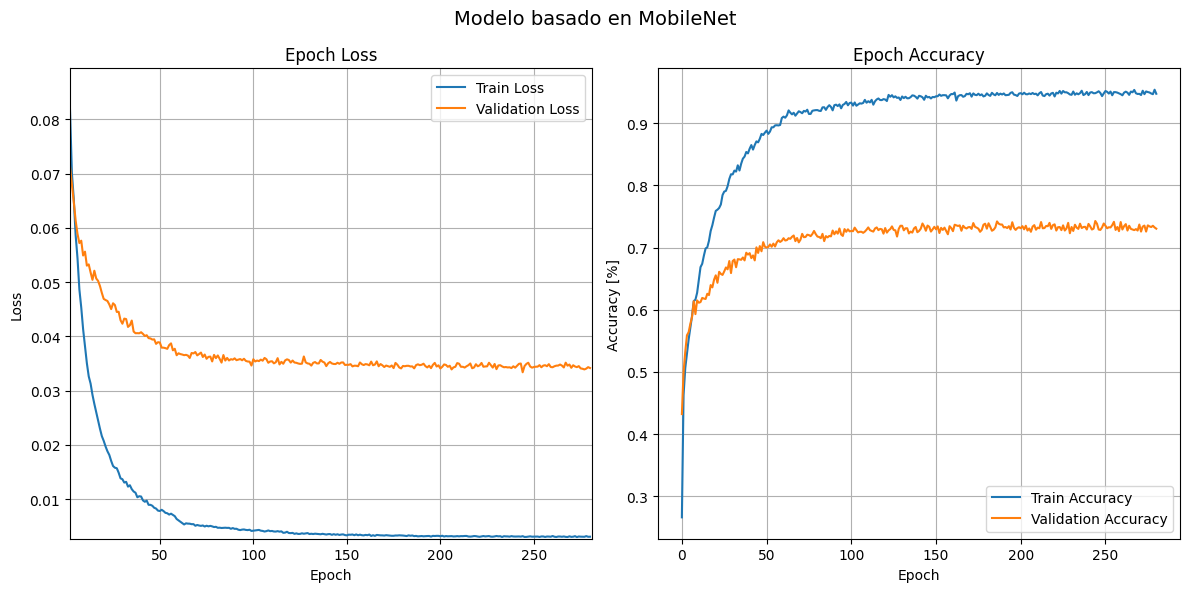

In [138]:
plot_metrics(model_mobilenet, title="Modelo basado en MobileNet")

## 3.6 Model based on Resnet18 with splitted outputs and all parameters trainable

### 3.6.1 Instantiation

In [21]:
# Instanciación del modelo con ResNet18
model_resnet18BTrainable = GazeEstimation_ResNet18Branch(name="resnet18branch_90_1e4_trainable", pretrained=True, trainable=True, debug=False) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet18BTrainable.dynamic_lr = True
model_resnet18BTrainable.minimum_lr = 1e-7
model_resnet18BTrainable.lr_epochs_adjustment = 60 # Cada 60 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18BTrainable.parameters(), lr=1e-4)

#Summary
summary(model_resnet18BTrainable.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 3.6.2 Training

In [62]:
model_resnet18BTrainable.fit(train_loader, val_loader, criterion, optimizer, epochs=90, device=device, save_model=True)

NameError: name 'model_resnet18BTrainable' is not defined

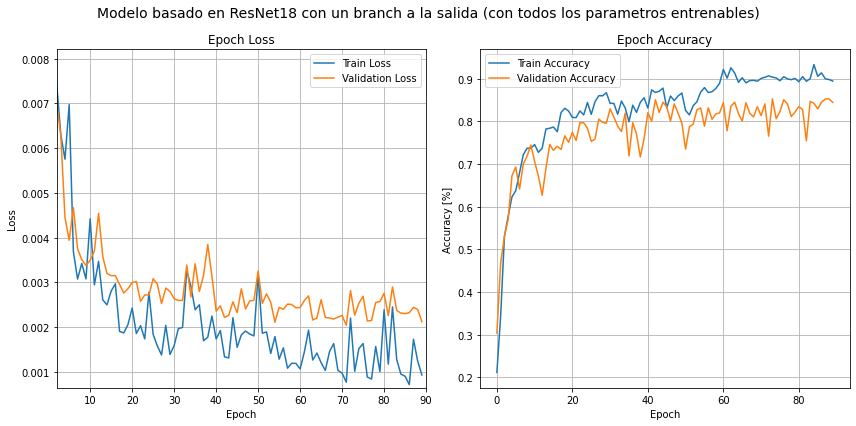

In [23]:
plot_metrics(model_resnet18BTrainable, title="Modelo basado en ResNet18 con un branch a la salida (con todos los parametros entrenables)")

## 4. Validation

Randomly pick an image and compare prediction VS groundtruth
- Blue arrow: real eye gaze.
- Green arrow: predicted eye gaze.

In [11]:
# Se elige el mejor modelo para validación
loaded_model = GazeEstimation_MobileNet()
loaded_model.load_state_dict(torch.load('./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth'))
loaded_model.to(device)

# Sanity check
inputs = torch.randn(8, 3, 90, 90).to(device) 
outputs = loaded_model(inputs) 

print(outputs)

/tmp/ipykernel_502866/3602844766.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('./modelos/gaze360/mobilenet__epochs_300__lr_1Em

tensor([[-0.0744, -0.1063],
        [-0.3688, -0.1978],
        [ 0.2048, -0.3650],
        [-0.3632, -0.1754],
        [-0.1970, -0.2691],
        [-0.1633, -0.2345],
        [ 0.2960, -0.0765],
        [-0.4414,  0.0087]], device='cuda:0', grad_fn=<CatBackward0>)


In [12]:
import time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Prediction time: 16.34ms 
Actual: 
	 pitch=-0.355 rad | yaw=-0.035 rad
	 proyección 2D del ángulo: 275.71° deg
Predicted: 
	 pitch=-0.219 rad | yaw=-0.029 rad
	 proyección 2D del ángulo: 277.57° deg
**Preciso (tolerancia = 20°): 1


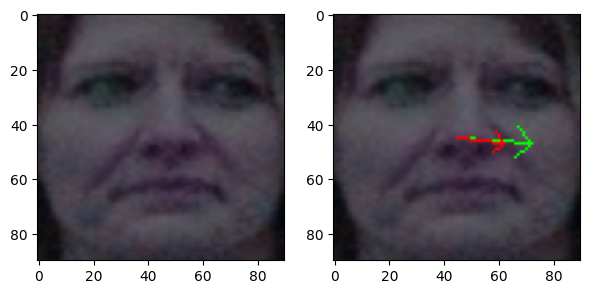

In [66]:
# Pick model
model = loaded_model

# Randomly select image and its labels
img, gaze = test_dataset[randint(0,len(test_dataset)-1)]
pitch = gaze[0]
yaw = gaze[1]
angle = angle_to_2d(np.array([gaze]))

# Get start time
start_time = time.time()

# Run inference and get prediction
predicted_gaze = model(img.unsqueeze(0).to(device))
pitch_predicted = predicted_gaze[0][0].item()
yaw_predicted = predicted_gaze[0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze.squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Get end time
end_time = time.time()

# Print prediction time
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time*1000:.2f}ms ")

# Define error tolerance
tolerancia = 20 # 15 degrees
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Print results
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Add annotations
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.imshow(img)
img = draw_gaze360_arrow(img,gaze,"center",scale=80)
img = draw_gaze360_arrow(img,predicted_gaze,"center",color=(255,0,0),scale=80)
# img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0), label="Predicted",label_y=22) #Prediced: green
# img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0),label="Actual",label_y=10) #Actual: blue

# Show images (after converting it from BGR to RGB)
plt.subplot(1,2,2)
plt.imshow(img)

## 5. Export best model to ONNX


In [69]:
import torch
import torch.onnx

# Assuming your model is already loaded or defined
model = loaded_model  # Replace with your model class
model.eval()  # Switch to evaluation mode

# Example input tensor matching the expected input size of your model
dummy_input = torch.randn(1, 3, 90, 90).to(device)  # Example input shape for CIFAR-10

# Export the model
torch.onnx.export(
    model, 
    dummy_input, 
    "./modelos/onnx/mobilenet_face.onnx",  # Output file
    export_params=True,  # Store the trained parameters
    opset_version=11,  # ONNX version
    input_names=['input'],  # Name of the input layer
    output_names=['gaze'],  # Name of the output layer
)


### 5.1 Verify ONNX exported model

[0.07058824 0.08392157 0.10718955 0.14065361 0.13568628 0.13010894
 0.12932463 0.151634   0.13551198 0.14671025]
PyTorch Output:
[[-0.34820962 -0.11759111]]
ONNX Output:
[array([[-0.34820887, -0.117591  ]], dtype=float32)]
Are the outputs similar? True


I0000 00:00:1734214180.045562  502866 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734214180.055877  611414 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1734214180.063843  611405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734214180.075796  611407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


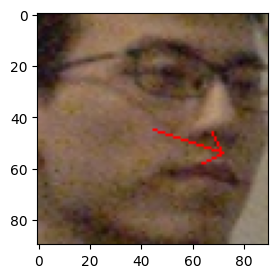

In [130]:
import onnxruntime as ort
from PIL import Image
from aux_functions import detect_face_bounding_box_from_array

# Load ONNX model
onnx_model_path = "./modelos/onnx/mobilenet_face.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Specify the path to your image
# image_path = "/home/idk/Downloads/photo_5010264429970959982_m.jpg"
image_path = "/home/idk/git/ceia/vpc2_project/datasets/Gaze360/imgs/rec_003/head/000165/001102.jpg"

# Define the necessary transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize((90, 90)),  # Resize the image to 224x224
])

# Load the image
image = Image.open(image_path).convert('RGB')  # Convert image to RGB
image_face = detect_face_bounding_box_from_array(np.array(image))

image_transformed = transform(image_face)

# Flatten the tensor (in row-major order) to match JavaScript processing
flattened_img_tensor = image_transformed.contiguous().view(-1).numpy()
print(flattened_img_tensor[:10])

# Apply the transformations
sample_input = image_transformed.unsqueeze(0)  # Add batch dimension



# Run inference with PyTorch model
with torch.no_grad():
    pytorch_output = loaded_model(sample_input.to(device))

# Convert PyTorch tensor to numpy (required for ONNX Runtime)
sample_input_np = sample_input.numpy()

# Prepare input for ONNX Runtime
onnx_inputs = {ort_session.get_inputs()[0].name: sample_input_np}

# Run inference with ONNX model
onnx_output = ort_session.run(None, onnx_inputs)

# Compare outputs
pytorch_output_np = pytorch_output.detach().cpu().numpy()

print("PyTorch Output:")
print(pytorch_output_np)

print("ONNX Output:")
print(onnx_output)

# Check if outputs are similar
comparison = np.allclose(pytorch_output_np, onnx_output[0], rtol=1e-03, atol=1e-05)
print(f"Are the outputs similar? {comparison}")

img = draw_gaze360_arrow((image_transformed.permute(1,2,0).numpy()*255).astype(np.uint8),np.array(onnx_output[0][0]),"center",color=(255,0,0),scale=80)
plt.figure(figsize=(3,3))
plt.imshow(img)

##  Metrics on TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 1793849), started 15:52:46 ago. (Use '!kill 1793849' to kill it.)

## 4. Ajuste de hiperparámetros


Realizamos una búsqueda de hiperpárametros con un dataset reducido para que no demore mucho tiempo. Se realizará una búsqueda aleatoria, entre un rango de valores definido. 

In [29]:
from aux_functions import getRandomHyperparam

In [50]:
# Defino los rangos que pueden tener los hiperparametros
parameters  = {
    "lr": np.geomspace(1e-3, 1e-5, 1000),
    "n_last_fc": np.arange(100, 4000),
    "n_brach_fc": np.arange(20, 1000),
}

# Obteneoms n set de hyperparametros a entrenar
hyperparams = getRandomHyperparam(16, parameters, seed=37)
hyperparams

[{'lr': 4.005000757873611e-05, 'n_last_fc': 2589, 'n_brach_fc': 113},
 {'lr': 1.2136237983442418e-05, 'n_last_fc': 2630, 'n_brach_fc': 701},
 {'lr': 1.8805040551285834e-05, 'n_last_fc': 3158, 'n_brach_fc': 874},
 {'lr': 5.0199651331100794e-05, 'n_last_fc': 2209, 'n_brach_fc': 56},
 {'lr': 5.089870193519685e-05, 'n_last_fc': 1612, 'n_brach_fc': 468},
 {'lr': 8.296958520834916e-05, 'n_last_fc': 3332, 'n_brach_fc': 130},
 {'lr': 3.986581073580439e-05, 'n_last_fc': 1971, 'n_brach_fc': 635},
 {'lr': 2.3462288481422625e-05, 'n_last_fc': 1254, 'n_brach_fc': 967},
 {'lr': 0.00016796748720926532, 'n_last_fc': 3115, 'n_brach_fc': 453},
 {'lr': 0.0001233363497913776, 'n_last_fc': 691, 'n_brach_fc': 839},
 {'lr': 1.0233165783302449e-05, 'n_last_fc': 3798, 'n_brach_fc': 878},
 {'lr': 0.000794145171902934, 'n_last_fc': 472, 'n_brach_fc': 443},
 {'lr': 0.0007044462277299037, 'n_last_fc': 2326, 'n_brach_fc': 315},
 {'lr': 1.2419213527017847e-05, 'n_last_fc': 1579, 'n_brach_fc': 683},
 {'lr': 3.6021065

In [44]:
# Generamos una version reducida del dataset
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=60)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de C:\Users\DELL\Documents\LSE\vpcII\tp\vpc2_project\datasets\MPIIFaceGaze.h5
Se cargaron 900 imagenes


In [45]:
# Separo en entrenamiento y validacion (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Entrenamiento



 Entrenamiento modelo: ResNet18Branch_HPT_4.01e-05_2589_113 


Epoch 1/25


Validation loss 0.02623: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0304 / 14.48% | Validation Loss / Accuracy: 0.0262 / 18.66%
Epoch 2/25


Validation loss 0.02479: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0222 / 21.37% | Validation Loss / Accuracy: 0.0248 / 18.97%
Epoch 3/25


Validation loss 0.02443: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0192 / 25.46% | Validation Loss / Accuracy: 0.0244 / 20.85%
Epoch 4/25


Validation loss 0.02385: 100%|███████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0156 / 28.25% | Validation Loss / Accuracy: 0.0239 / 19.06%
Epoch 5/25


Validation loss 0.02157: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0138 / 31.09% | Validation Loss / Accuracy: 0.0216 / 22.54%
Epoch 6/25


Validation loss 0.02067: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0123 / 39.09% | Validation Loss / Accuracy: 0.0207 / 31.21%
Epoch 7/25


Validation loss 0.01965: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0101 / 42.50% | Validation Loss / Accuracy: 0.0197 / 27.28%
Epoch 8/25


Validation loss 0.01871: 100%|███████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0087 / 45.03% | Validation Loss / Accuracy: 0.0187 / 25.40%
Epoch 9/25


Validation loss 0.02010: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0072 / 52.99% | Validation Loss / Accuracy: 0.0201 / 24.73%
Epoch 10/25


Validation loss 0.01450: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0061 / 54.65% | Validation Loss / Accuracy: 0.0145 / 32.46%
Epoch 11/25


Validation loss 0.01700: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0053 / 55.22% | Validation Loss / Accuracy: 0.0170 / 34.06%
Epoch 12/25


Validation loss 0.01606: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0056 / 59.61% | Validation Loss / Accuracy: 0.0161 / 27.86%
Epoch 13/25


Validation loss 0.01440: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0050 / 57.64% | Validation Loss / Accuracy: 0.0144 / 36.56%
Epoch 14/25


Validation loss 0.01571: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0045 / 62.15% | Validation Loss / Accuracy: 0.0157 / 29.15%
Epoch 15/25


Validation loss 0.01594: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0042 / 64.05% | Validation Loss / Accuracy: 0.0159 / 28.17%
Epoch 16/25


Validation loss 0.01298: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0040 / 68.39% | Validation Loss / Accuracy: 0.0130 / 33.21%
Epoch 17/25


Validation loss 0.01421: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0036 / 65.23% | Validation Loss / Accuracy: 0.0142 / 33.53%
Epoch 18/25


Validation loss 0.01195: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0036 / 66.38% | Validation Loss / Accuracy: 0.0120 / 35.45%
Epoch 19/25


Validation loss 0.01248: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0033 / 69.88% | Validation Loss / Accuracy: 0.0125 / 34.33%
Epoch 20/25


Validation loss 0.01354: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0037 / 66.44% | Validation Loss / Accuracy: 0.0135 / 33.84%
Epoch 21/25


Validation loss 0.01247: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0039 / 62.42% | Validation Loss / Accuracy: 0.0125 / 33.04%
Epoch 22/25


Validation loss 0.01093: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0034 / 68.26% | Validation Loss / Accuracy: 0.0109 / 40.00%
Epoch 23/25


Validation loss 0.01231: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0032 / 70.16% | Validation Loss / Accuracy: 0.0123 / 31.47%
Epoch 24/25


Validation loss 0.01194: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.80s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0028 / 70.94% | Validation Loss / Accuracy: 0.0119 / 34.60%
Epoch 25/25


Validation loss 0.01184: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0029 / 72.78% | Validation Loss / Accuracy: 0.0118 / 33.21%


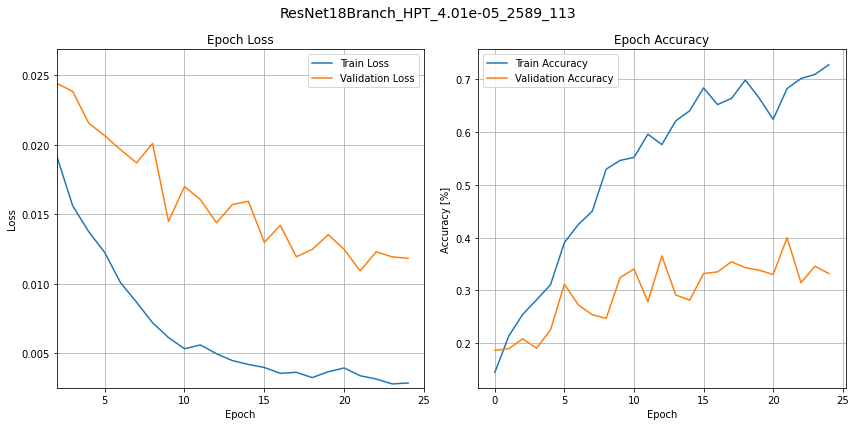



 Entrenamiento modelo: ResNet18Branch_HPT_1.21e-05_2630_701 


Epoch 1/25


Validation loss 0.02711: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0358 / 13.64% | Validation Loss / Accuracy: 0.0271 / 19.91%
Epoch 2/25


Validation loss 0.02547: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0271 / 19.81% | Validation Loss / Accuracy: 0.0255 / 22.77%
Epoch 3/25


Validation loss 0.02430: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0260 / 18.98% | Validation Loss / Accuracy: 0.0243 / 22.59%
Epoch 4/25


Validation loss 0.02342: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0216 / 19.35% | Validation Loss / Accuracy: 0.0234 / 22.14%
Epoch 5/25


Validation loss 0.02409: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0223 / 21.95% | Validation Loss / Accuracy: 0.0241 / 15.67%
Epoch 6/25


Validation loss 0.02475: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0203 / 23.26% | Validation Loss / Accuracy: 0.0247 / 20.98%
Epoch 7/25


Validation loss 0.02226: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0199 / 22.04% | Validation Loss / Accuracy: 0.0223 / 21.47%
Epoch 8/25


Validation loss 0.02481: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0184 / 25.91% | Validation Loss / Accuracy: 0.0248 / 14.69%
Epoch 9/25


Validation loss 0.02402: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0164 / 30.36% | Validation Loss / Accuracy: 0.0240 / 19.42%
Epoch 10/25


Validation loss 0.02091: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0157 / 28.28% | Validation Loss / Accuracy: 0.0209 / 24.91%
Epoch 11/25


Validation loss 0.02288: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0146 / 30.39% | Validation Loss / Accuracy: 0.0229 / 21.29%
Epoch 12/25


Validation loss 0.02158: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0141 / 30.43% | Validation Loss / Accuracy: 0.0216 / 25.09%
Epoch 13/25


Validation loss 0.02315: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0129 / 36.08% | Validation Loss / Accuracy: 0.0232 / 20.71%
Epoch 14/25


Validation loss 0.02096: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0122 / 34.58% | Validation Loss / Accuracy: 0.0210 / 24.64%
Epoch 15/25


Validation loss 0.01892: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0114 / 36.56% | Validation Loss / Accuracy: 0.0189 / 24.29%
Epoch 16/25


Validation loss 0.01940: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0105 / 40.24% | Validation Loss / Accuracy: 0.0194 / 24.11%
Epoch 17/25


Validation loss 0.01994: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0096 / 42.85% | Validation Loss / Accuracy: 0.0199 / 31.65%
Epoch 18/25


Validation loss 0.02370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0092 / 42.99% | Validation Loss / Accuracy: 0.0237 / 20.00%
Epoch 19/25


Validation loss 0.02041: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0097 / 46.28% | Validation Loss / Accuracy: 0.0204 / 21.12%
Epoch 20/25


Validation loss 0.02034: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0094 / 46.66% | Validation Loss / Accuracy: 0.0203 / 28.84%
Epoch 21/25


Validation loss 0.01840: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0091 / 44.68% | Validation Loss / Accuracy: 0.0184 / 31.70%
Epoch 22/25


Validation loss 0.02120: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0080 / 45.21% | Validation Loss / Accuracy: 0.0212 / 25.36%
Epoch 23/25


Validation loss 0.02031: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0084 / 45.79% | Validation Loss / Accuracy: 0.0203 / 31.52%
Epoch 24/25


Validation loss 0.01921: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0078 / 50.27% | Validation Loss / Accuracy: 0.0192 / 31.70%
Epoch 25/25


Validation loss 0.01827: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0063 / 54.84% | Validation Loss / Accuracy: 0.0183 / 26.29%


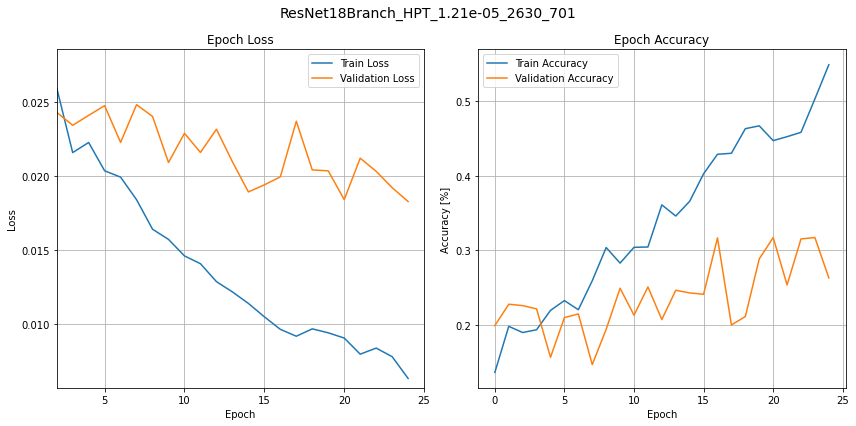



 Entrenamiento modelo: ResNet18Branch_HPT_1.88e-05_3158_874 


Epoch 1/25


Validation loss 0.02423: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0450 / 11.89% | Validation Loss / Accuracy: 0.0242 / 21.21%
Epoch 2/25


Validation loss 0.02674: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0271 / 20.72% | Validation Loss / Accuracy: 0.0267 / 19.96%
Epoch 3/25


Validation loss 0.02415: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0232 / 22.35% | Validation Loss / Accuracy: 0.0241 / 20.22%
Epoch 4/25


Validation loss 0.02374: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0197 / 26.59% | Validation Loss / Accuracy: 0.0237 / 21.52%
Epoch 5/25


Validation loss 0.02211: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0187 / 24.13% | Validation Loss / Accuracy: 0.0221 / 20.49%
Epoch 6/25


Validation loss 0.02356: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0162 / 30.68% | Validation Loss / Accuracy: 0.0236 / 22.10%
Epoch 7/25


Validation loss 0.02416: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0154 / 30.11% | Validation Loss / Accuracy: 0.0242 / 21.61%
Epoch 8/25


Validation loss 0.02119: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0132 / 33.89% | Validation Loss / Accuracy: 0.0212 / 25.27%
Epoch 9/25


Validation loss 0.01941: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0127 / 36.55% | Validation Loss / Accuracy: 0.0194 / 30.40%
Epoch 10/25


Validation loss 0.02081: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0115 / 41.24% | Validation Loss / Accuracy: 0.0208 / 27.28%
Epoch 11/25


Validation loss 0.01912: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0099 / 41.48% | Validation Loss / Accuracy: 0.0191 / 23.35%
Epoch 12/25


Validation loss 0.01890: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0087 / 45.78% | Validation Loss / Accuracy: 0.0189 / 26.47%
Epoch 13/25


Validation loss 0.01689: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0087 / 44.40% | Validation Loss / Accuracy: 0.0169 / 30.76%
Epoch 14/25


Validation loss 0.01726: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0077 / 49.61% | Validation Loss / Accuracy: 0.0173 / 28.26%
Epoch 15/25


Validation loss 0.01723: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0071 / 50.12% | Validation Loss / Accuracy: 0.0172 / 30.54%
Epoch 16/25


Validation loss 0.01701: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0074 / 50.03% | Validation Loss / Accuracy: 0.0170 / 32.63%
Epoch 17/25


Validation loss 0.01616: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0064 / 56.42% | Validation Loss / Accuracy: 0.0162 / 29.42%
Epoch 18/25


Validation loss 0.01654: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0060 / 54.12% | Validation Loss / Accuracy: 0.0165 / 28.93%
Epoch 19/25


Validation loss 0.01615: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0059 / 55.62% | Validation Loss / Accuracy: 0.0162 / 24.60%
Epoch 20/25


Validation loss 0.01441: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0057 / 57.71% | Validation Loss / Accuracy: 0.0144 / 32.77%
Epoch 21/25


Validation loss 0.01569: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0059 / 53.45% | Validation Loss / Accuracy: 0.0157 / 29.91%
Epoch 22/25


Validation loss 0.01527: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0051 / 57.11% | Validation Loss / Accuracy: 0.0153 / 25.98%
Epoch 23/25


Validation loss 0.01492: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0055 / 60.17% | Validation Loss / Accuracy: 0.0149 / 33.39%
Epoch 24/25


Validation loss 0.01436: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0045 / 59.68% | Validation Loss / Accuracy: 0.0144 / 33.84%
Epoch 25/25


Validation loss 0.01606: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0045 / 65.71% | Validation Loss / Accuracy: 0.0161 / 28.97%


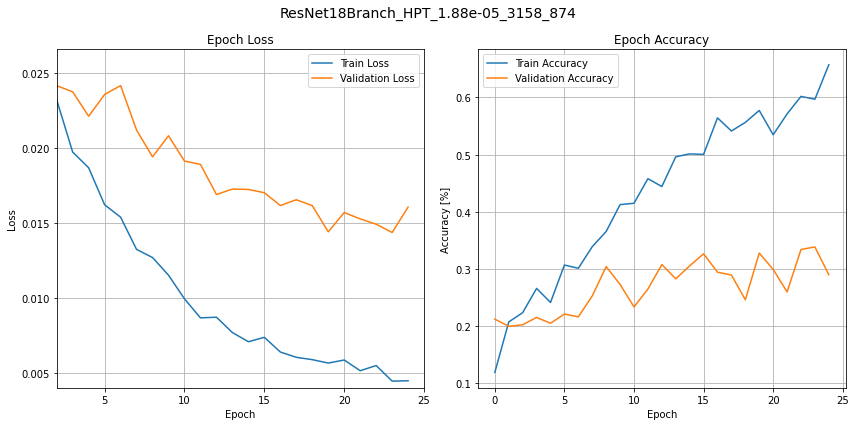



 Entrenamiento modelo: ResNet18Branch_HPT_5.02e-05_2209_56 


Epoch 1/25


Validation loss 0.02745: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0282 / 16.64% | Validation Loss / Accuracy: 0.0274 / 23.04%
Epoch 2/25


Validation loss 0.02383: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0214 / 18.97% | Validation Loss / Accuracy: 0.0238 / 25.00%
Epoch 3/25


Validation loss 0.02119: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0173 / 26.23% | Validation Loss / Accuracy: 0.0212 / 20.67%
Epoch 4/25


Validation loss 0.02153: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0140 / 32.48% | Validation Loss / Accuracy: 0.0215 / 21.88%
Epoch 5/25


Validation loss 0.01823: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0113 / 35.54% | Validation Loss / Accuracy: 0.0182 / 28.21%
Epoch 6/25


Validation loss 0.01835: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0101 / 40.28% | Validation Loss / Accuracy: 0.0183 / 32.81%
Epoch 7/25


Validation loss 0.01676: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0082 / 47.09% | Validation Loss / Accuracy: 0.0168 / 26.61%
Epoch 8/25


Validation loss 0.01831: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0070 / 49.16% | Validation Loss / Accuracy: 0.0183 / 24.11%
Epoch 9/25


Validation loss 0.01731: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0061 / 52.09% | Validation Loss / Accuracy: 0.0173 / 29.02%
Epoch 10/25


Validation loss 0.01559: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0053 / 56.61% | Validation Loss / Accuracy: 0.0156 / 34.20%
Epoch 11/25


Validation loss 0.01485: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0050 / 58.34% | Validation Loss / Accuracy: 0.0149 / 29.46%
Epoch 12/25


Validation loss 0.01427: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0045 / 62.93% | Validation Loss / Accuracy: 0.0143 / 28.53%
Epoch 13/25


Validation loss 0.01508: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0041 / 62.55% | Validation Loss / Accuracy: 0.0151 / 37.50%
Epoch 14/25


Validation loss 0.01387: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0038 / 64.66% | Validation Loss / Accuracy: 0.0139 / 25.54%
Epoch 15/25


Validation loss 0.01397: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0037 / 66.98% | Validation Loss / Accuracy: 0.0140 / 31.38%
Epoch 16/25


Validation loss 0.01301: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0032 / 71.78% | Validation Loss / Accuracy: 0.0130 / 36.56%
Epoch 17/25


Validation loss 0.01380: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0034 / 68.19% | Validation Loss / Accuracy: 0.0138 / 34.46%
Epoch 18/25


Validation loss 0.01338: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0033 / 72.60% | Validation Loss / Accuracy: 0.0134 / 31.16%
Epoch 19/25


Validation loss 0.01315: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0029 / 72.52% | Validation Loss / Accuracy: 0.0131 / 36.12%
Epoch 20/25


Validation loss 0.01277: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0029 / 71.37% | Validation Loss / Accuracy: 0.0128 / 32.28%
Epoch 21/25


Validation loss 0.01238: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0027 / 75.43% | Validation Loss / Accuracy: 0.0124 / 32.59%
Epoch 22/25


Validation loss 0.01082: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0024 / 75.97% | Validation Loss / Accuracy: 0.0108 / 36.07%
Epoch 23/25


Validation loss 0.01205: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0025 / 76.53% | Validation Loss / Accuracy: 0.0121 / 31.65%
Epoch 24/25


Validation loss 0.01090: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0026 / 74.71% | Validation Loss / Accuracy: 0.0109 / 35.76%
Epoch 25/25


Validation loss 0.00993: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0025 / 75.32% | Validation Loss / Accuracy: 0.0099 / 38.88%


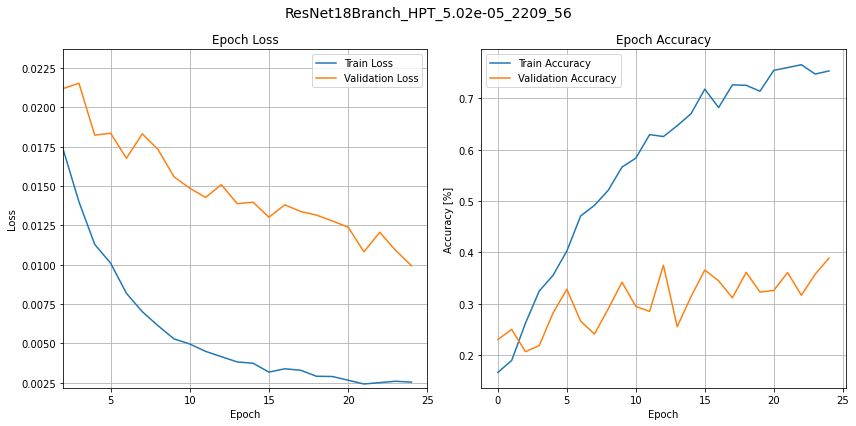



 Entrenamiento modelo: ResNet18Branch_HPT_5.09e-05_1612_468 


Epoch 1/25


Validation loss 0.03482: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0353 / 14.18% | Validation Loss / Accuracy: 0.0348 / 15.36%
Epoch 2/25


Validation loss 0.02524: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0233 / 21.71% | Validation Loss / Accuracy: 0.0252 / 17.68%
Epoch 3/25


Validation loss 0.02282: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0176 / 27.11% | Validation Loss / Accuracy: 0.0228 / 22.28%
Epoch 4/25


Validation loss 0.02246: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0159 / 29.46% | Validation Loss / Accuracy: 0.0225 / 21.92%
Epoch 5/25


Validation loss 0.02141: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0122 / 35.28% | Validation Loss / Accuracy: 0.0214 / 26.96%
Epoch 6/25


Validation loss 0.01743: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0104 / 43.32% | Validation Loss / Accuracy: 0.0174 / 30.45%
Epoch 7/25


Validation loss 0.01883: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0100 / 40.86% | Validation Loss / Accuracy: 0.0188 / 30.89%
Epoch 8/25


Validation loss 0.01916: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0077 / 46.56% | Validation Loss / Accuracy: 0.0192 / 25.85%
Epoch 9/25


Validation loss 0.01691: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0066 / 52.07% | Validation Loss / Accuracy: 0.0169 / 26.47%
Epoch 10/25


Validation loss 0.01711: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0056 / 55.52% | Validation Loss / Accuracy: 0.0171 / 30.09%
Epoch 11/25


Validation loss 0.01501: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0053 / 55.67% | Validation Loss / Accuracy: 0.0150 / 32.95%
Epoch 12/25


Validation loss 0.01398: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0049 / 59.13% | Validation Loss / Accuracy: 0.0140 / 34.96%
Epoch 13/25


Validation loss 0.01434: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0047 / 61.72% | Validation Loss / Accuracy: 0.0143 / 29.73%
Epoch 14/25


Validation loss 0.01455: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0047 / 61.19% | Validation Loss / Accuracy: 0.0146 / 31.96%
Epoch 15/25


Validation loss 0.01588: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0040 / 66.68% | Validation Loss / Accuracy: 0.0159 / 32.01%
Epoch 16/25


Validation loss 0.01391: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0046 / 60.77% | Validation Loss / Accuracy: 0.0139 / 34.20%
Epoch 17/25


Validation loss 0.01288: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0039 / 66.27% | Validation Loss / Accuracy: 0.0129 / 31.61%
Epoch 18/25


Validation loss 0.01242: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0035 / 67.11% | Validation Loss / Accuracy: 0.0124 / 40.80%
Epoch 19/25


Validation loss 0.01286: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0036 / 68.76% | Validation Loss / Accuracy: 0.0129 / 38.26%
Epoch 20/25


Validation loss 0.01289: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0031 / 71.16% | Validation Loss / Accuracy: 0.0129 / 33.21%
Epoch 21/25


Validation loss 0.01270: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0029 / 69.51% | Validation Loss / Accuracy: 0.0127 / 32.23%
Epoch 22/25


Validation loss 0.01294: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0029 / 73.32% | Validation Loss / Accuracy: 0.0129 / 37.05%
Epoch 23/25


Validation loss 0.01152: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0031 / 70.38% | Validation Loss / Accuracy: 0.0115 / 34.02%
Epoch 24/25


Validation loss 0.01136: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0032 / 71.07% | Validation Loss / Accuracy: 0.0114 / 32.41%
Epoch 25/25


Validation loss 0.01210: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0029 / 71.09% | Validation Loss / Accuracy: 0.0121 / 36.07%


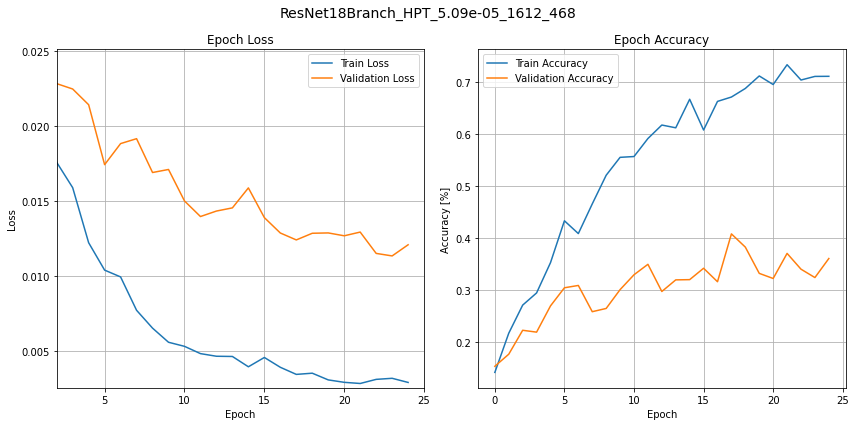



 Entrenamiento modelo: ResNet18Branch_HPT_8.30e-05_3332_130 


Epoch 1/25


Validation loss 0.02669: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0395 / 18.85% | Validation Loss / Accuracy: 0.0267 / 20.71%
Epoch 2/25


Validation loss 0.02352: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0229 / 19.82% | Validation Loss / Accuracy: 0.0235 / 19.73%
Epoch 3/25


Validation loss 0.02086: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0191 / 22.19% | Validation Loss / Accuracy: 0.0209 / 22.90%
Epoch 4/25


Validation loss 0.01915: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0147 / 26.53% | Validation Loss / Accuracy: 0.0191 / 24.60%
Epoch 5/25


Validation loss 0.01911: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0108 / 37.98% | Validation Loss / Accuracy: 0.0191 / 21.12%
Epoch 6/25


Validation loss 0.01552: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0092 / 43.85% | Validation Loss / Accuracy: 0.0155 / 30.27%
Epoch 7/25


Validation loss 0.01494: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0073 / 45.13% | Validation Loss / Accuracy: 0.0149 / 32.14%
Epoch 8/25


Validation loss 0.01505: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0061 / 55.91% | Validation Loss / Accuracy: 0.0150 / 36.43%
Epoch 9/25


Validation loss 0.01395: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0049 / 57.49% | Validation Loss / Accuracy: 0.0140 / 33.39%
Epoch 10/25


Validation loss 0.01278: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0042 / 65.66% | Validation Loss / Accuracy: 0.0128 / 33.53%
Epoch 11/25


Validation loss 0.01294: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0035 / 68.64% | Validation Loss / Accuracy: 0.0129 / 39.20%
Epoch 12/25


Validation loss 0.01245: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0038 / 66.86% | Validation Loss / Accuracy: 0.0124 / 32.41%
Epoch 13/25


Validation loss 0.01261: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0033 / 74.10% | Validation Loss / Accuracy: 0.0126 / 35.80%
Epoch 14/25


Validation loss 0.01031: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0035 / 66.48% | Validation Loss / Accuracy: 0.0103 / 36.96%
Epoch 15/25


Validation loss 0.01017: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0029 / 76.15% | Validation Loss / Accuracy: 0.0102 / 44.73%
Epoch 16/25


Validation loss 0.01093: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0030 / 70.45% | Validation Loss / Accuracy: 0.0109 / 35.71%
Epoch 17/25


Validation loss 0.00985: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0030 / 69.59% | Validation Loss / Accuracy: 0.0098 / 45.49%
Epoch 18/25


Validation loss 0.01061: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0024 / 75.06% | Validation Loss / Accuracy: 0.0106 / 37.41%
Epoch 19/25


Validation loss 0.01127: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0028 / 71.77% | Validation Loss / Accuracy: 0.0113 / 40.89%
Epoch 20/25


Validation loss 0.00980: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0023 / 79.24% | Validation Loss / Accuracy: 0.0098 / 36.65%
Epoch 21/25


Validation loss 0.00982: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0021 / 78.77% | Validation Loss / Accuracy: 0.0098 / 43.48%
Epoch 22/25


Validation loss 0.01134: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0020 / 80.72% | Validation Loss / Accuracy: 0.0113 / 45.58%
Epoch 23/25


Validation loss 0.01016: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0018 / 81.17% | Validation Loss / Accuracy: 0.0102 / 44.69%
Epoch 24/25


Validation loss 0.01087: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0019 / 81.52% | Validation Loss / Accuracy: 0.0109 / 38.48%
Epoch 25/25


Validation loss 0.00930: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0021 / 79.11% | Validation Loss / Accuracy: 0.0093 / 43.53%


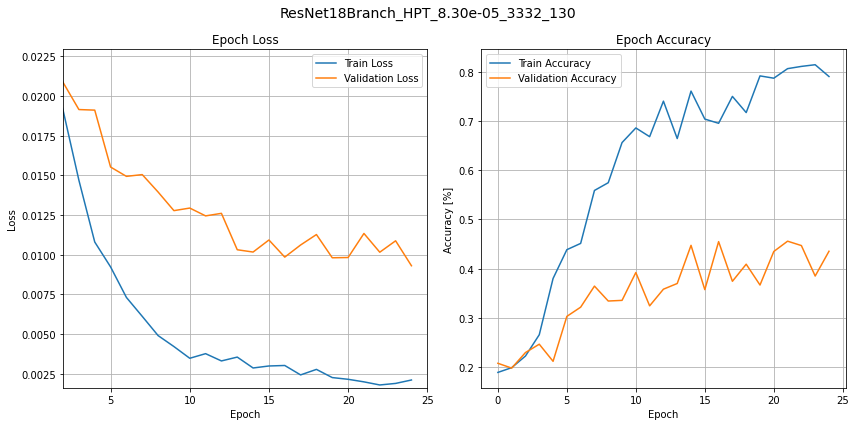



 Entrenamiento modelo: ResNet18Branch_HPT_3.99e-05_1971_635 


Epoch 1/25


Validation loss 0.02234: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0295 / 18.94% | Validation Loss / Accuracy: 0.0223 / 23.88%
Epoch 2/25


Validation loss 0.02474: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0217 / 20.90% | Validation Loss / Accuracy: 0.0247 / 18.17%
Epoch 3/25


Validation loss 0.02514: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0183 / 24.00% | Validation Loss / Accuracy: 0.0251 / 20.49%
Epoch 4/25


Validation loss 0.01979: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0149 / 31.52% | Validation Loss / Accuracy: 0.0198 / 25.76%
Epoch 5/25


Validation loss 0.02186: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0126 / 36.52% | Validation Loss / Accuracy: 0.0219 / 24.29%
Epoch 6/25


Validation loss 0.01986: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0110 / 40.23% | Validation Loss / Accuracy: 0.0199 / 25.80%
Epoch 7/25


Validation loss 0.01892: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0090 / 46.12% | Validation Loss / Accuracy: 0.0189 / 32.63%
Epoch 8/25


Validation loss 0.01936: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0081 / 47.50% | Validation Loss / Accuracy: 0.0194 / 26.03%
Epoch 9/25


Validation loss 0.01840: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0074 / 46.69% | Validation Loss / Accuracy: 0.0184 / 28.57%
Epoch 10/25


Validation loss 0.01901: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0068 / 53.17% | Validation Loss / Accuracy: 0.0190 / 28.84%
Epoch 11/25


Validation loss 0.01745: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0064 / 54.38% | Validation Loss / Accuracy: 0.0175 / 27.10%
Epoch 12/25


Validation loss 0.01613: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0064 / 54.13% | Validation Loss / Accuracy: 0.0161 / 32.28%
Epoch 13/25


Validation loss 0.01713: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0063 / 52.29% | Validation Loss / Accuracy: 0.0171 / 30.89%
Epoch 14/25


Validation loss 0.01660: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0051 / 60.68% | Validation Loss / Accuracy: 0.0166 / 31.65%
Epoch 15/25


Validation loss 0.01822: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0047 / 61.44% | Validation Loss / Accuracy: 0.0182 / 26.79%
Epoch 16/25


Validation loss 0.01624: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0048 / 59.05% | Validation Loss / Accuracy: 0.0162 / 30.94%
Epoch 17/25


Validation loss 0.01633: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0049 / 59.07% | Validation Loss / Accuracy: 0.0163 / 25.98%
Epoch 18/25


Validation loss 0.01479: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0042 / 58.75% | Validation Loss / Accuracy: 0.0148 / 28.17%
Epoch 19/25


Validation loss 0.01397: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0049 / 59.45% | Validation Loss / Accuracy: 0.0140 / 35.40%
Epoch 20/25


Validation loss 0.01888: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0039 / 65.40% | Validation Loss / Accuracy: 0.0189 / 28.17%
Epoch 21/25


Validation loss 0.01478: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0046 / 61.38% | Validation Loss / Accuracy: 0.0148 / 32.28%
Epoch 22/25


Validation loss 0.01309: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0034 / 66.94% | Validation Loss / Accuracy: 0.0131 / 35.00%
Epoch 23/25


Validation loss 0.01381: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0031 / 70.32% | Validation Loss / Accuracy: 0.0138 / 32.77%
Epoch 24/25


Validation loss 0.01330: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0030 / 69.59% | Validation Loss / Accuracy: 0.0133 / 30.13%
Epoch 25/25


Validation loss 0.01541: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0036 / 65.33% | Validation Loss / Accuracy: 0.0154 / 28.97%


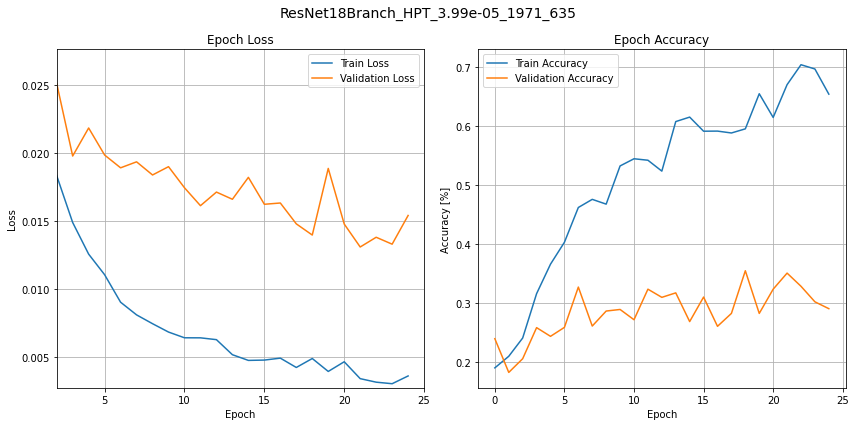



 Entrenamiento modelo: ResNet18Branch_HPT_2.35e-05_1254_967 


Epoch 1/25


Validation loss 0.02898: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0310 / 19.76% | Validation Loss / Accuracy: 0.0290 / 15.31%
Epoch 2/25


Validation loss 0.02396: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0246 / 20.59% | Validation Loss / Accuracy: 0.0240 / 18.79%
Epoch 3/25


Validation loss 0.02095: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0222 / 18.98% | Validation Loss / Accuracy: 0.0209 / 22.14%
Epoch 4/25


Validation loss 0.02148: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0192 / 23.89% | Validation Loss / Accuracy: 0.0215 / 22.59%
Epoch 5/25


Validation loss 0.02039: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0182 / 25.53% | Validation Loss / Accuracy: 0.0204 / 22.59%
Epoch 6/25


Validation loss 0.02218: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0160 / 29.84% | Validation Loss / Accuracy: 0.0222 / 17.99%
Epoch 7/25


Validation loss 0.02025: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0143 / 32.00% | Validation Loss / Accuracy: 0.0202 / 17.37%
Epoch 8/25


Validation loss 0.01781: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0132 / 32.09% | Validation Loss / Accuracy: 0.0178 / 26.07%
Epoch 9/25


Validation loss 0.01887: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0114 / 38.18% | Validation Loss / Accuracy: 0.0189 / 28.26%
Epoch 10/25


Validation loss 0.02119: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0113 / 41.23% | Validation Loss / Accuracy: 0.0212 / 28.04%
Epoch 11/25


Validation loss 0.01891: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0094 / 43.82% | Validation Loss / Accuracy: 0.0189 / 24.11%
Epoch 12/25


Validation loss 0.01925: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0091 / 44.61% | Validation Loss / Accuracy: 0.0193 / 29.51%
Epoch 13/25


Validation loss 0.02008: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0079 / 49.52% | Validation Loss / Accuracy: 0.0201 / 28.21%
Epoch 14/25


Validation loss 0.01950: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Se interrumpió el entrenamiento porque en los últimos 6 epochs no se logró menor loss que el mínimo (min:0.01781217185780406)


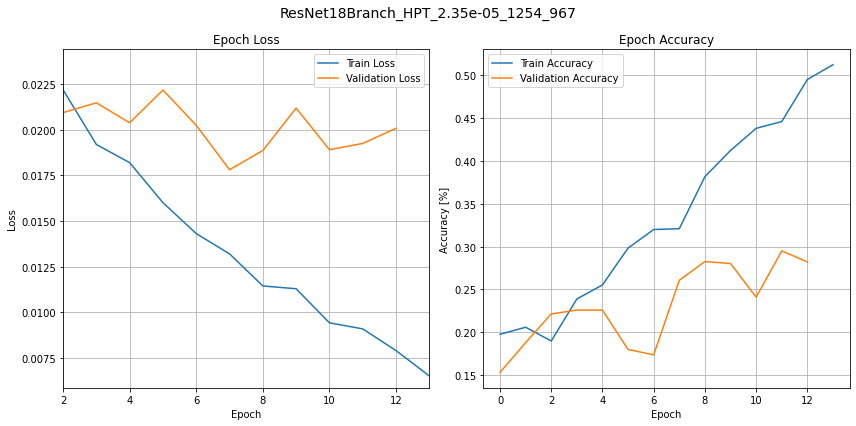



 Entrenamiento modelo: ResNet18Branch_HPT_1.68e-04_3115_453 


Epoch 1/25


Validation loss 0.03878: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0813 / 18.20% | Validation Loss / Accuracy: 0.0388 / 12.54%
Epoch 2/25


Validation loss 0.02505: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0260 / 20.47% | Validation Loss / Accuracy: 0.0251 / 21.29%
Epoch 3/25


Validation loss 0.02370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0182 / 24.84% | Validation Loss / Accuracy: 0.0237 / 22.72%
Epoch 4/25


Validation loss 0.01600: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0114 / 36.40% | Validation Loss / Accuracy: 0.0160 / 32.63%
Epoch 5/25


Validation loss 0.01353: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0082 / 43.17% | Validation Loss / Accuracy: 0.0135 / 34.78%
Epoch 6/25


Validation loss 0.01370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0063 / 52.59% | Validation Loss / Accuracy: 0.0137 / 32.28%
Epoch 7/25


Validation loss 0.01004: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0051 / 59.76% | Validation Loss / Accuracy: 0.0100 / 39.82%
Epoch 8/25


Validation loss 0.01050: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0036 / 66.81% | Validation Loss / Accuracy: 0.0105 / 44.02%
Epoch 9/25


Validation loss 0.01051: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0030 / 71.04% | Validation Loss / Accuracy: 0.0105 / 40.40%
Epoch 10/25


Validation loss 0.00819: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0031 / 68.47% | Validation Loss / Accuracy: 0.0082 / 44.69%
Epoch 11/25


Validation loss 0.00882: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0026 / 70.60% | Validation Loss / Accuracy: 0.0088 / 43.57%
Epoch 12/25


Validation loss 0.00824: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0022 / 76.28% | Validation Loss / Accuracy: 0.0082 / 48.44%
Epoch 13/25


Validation loss 0.00824: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0023 / 76.53% | Validation Loss / Accuracy: 0.0082 / 45.13%
Epoch 14/25


Validation loss 0.00841: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0020 / 79.53% | Validation Loss / Accuracy: 0.0084 / 46.56%
Epoch 15/25


Validation loss 0.00777: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0019 / 80.97% | Validation Loss / Accuracy: 0.0078 / 44.33%
Epoch 16/25


Validation loss 0.00736: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0018 / 81.12% | Validation Loss / Accuracy: 0.0074 / 48.57%
Epoch 17/25


Validation loss 0.00699: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 84.36% | Validation Loss / Accuracy: 0.0070 / 48.44%
Epoch 18/25


Validation loss 0.00728: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 80.71% | Validation Loss / Accuracy: 0.0073 / 46.43%
Epoch 19/25


Validation loss 0.00728: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0016 / 83.23% | Validation Loss / Accuracy: 0.0073 / 54.11%
Epoch 20/25


Validation loss 0.00692: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0014 / 84.40% | Validation Loss / Accuracy: 0.0069 / 49.55%
Epoch 21/25


Validation loss 0.00711: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0015 / 83.62% | Validation Loss / Accuracy: 0.0071 / 49.69%
Epoch 22/25


Validation loss 0.00655: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 83.50% | Validation Loss / Accuracy: 0.0065 / 57.72%
Epoch 23/25


Validation loss 0.00695: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0014 / 85.99% | Validation Loss / Accuracy: 0.0070 / 49.02%
Epoch 24/25


Validation loss 0.00724: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 82.55% | Validation Loss / Accuracy: 0.0072 / 49.60%
Epoch 25/25


Validation loss 0.00759: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 78.63% | Validation Loss / Accuracy: 0.0076 / 43.39%


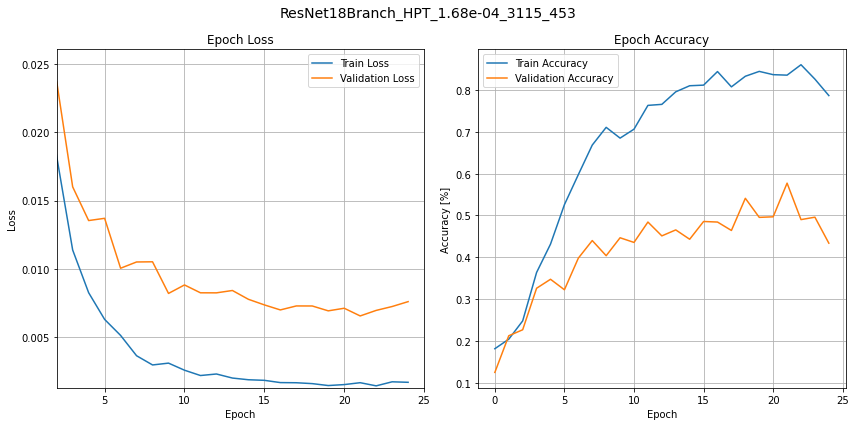



 Entrenamiento modelo: ResNet18Branch_HPT_1.23e-04_691_839 


Epoch 1/25


Validation loss 0.02577: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0321 / 17.70% | Validation Loss / Accuracy: 0.0258 / 24.02%
Epoch 2/25


Validation loss 0.02300: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0192 / 25.52% | Validation Loss / Accuracy: 0.0230 / 18.66%
Epoch 3/25


Validation loss 0.01902: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0148 / 32.80% | Validation Loss / Accuracy: 0.0190 / 28.39%
Epoch 4/25


Validation loss 0.01874: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0110 / 37.89% | Validation Loss / Accuracy: 0.0187 / 28.35%
Epoch 5/25


Validation loss 0.01528: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0080 / 47.66% | Validation Loss / Accuracy: 0.0153 / 28.35%
Epoch 6/25


Validation loss 0.01444: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0068 / 52.66% | Validation Loss / Accuracy: 0.0144 / 30.71%
Epoch 7/25


Validation loss 0.01726: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0053 / 58.68% | Validation Loss / Accuracy: 0.0173 / 29.15%
Epoch 8/25


Validation loss 0.01344: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0052 / 60.61% | Validation Loss / Accuracy: 0.0134 / 35.13%
Epoch 9/25


Validation loss 0.01169: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0040 / 64.31% | Validation Loss / Accuracy: 0.0117 / 37.32%
Epoch 10/25


Validation loss 0.01078: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0035 / 68.94% | Validation Loss / Accuracy: 0.0108 / 37.28%
Epoch 11/25


Validation loss 0.01060: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0034 / 67.95% | Validation Loss / Accuracy: 0.0106 / 42.50%
Epoch 12/25


Validation loss 0.01121: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0028 / 70.01% | Validation Loss / Accuracy: 0.0112 / 38.88%
Epoch 13/25


Validation loss 0.00957: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0026 / 75.54% | Validation Loss / Accuracy: 0.0096 / 46.96%
Epoch 14/25


Validation loss 0.00962: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0029 / 74.18% | Validation Loss / Accuracy: 0.0096 / 38.57%
Epoch 15/25


Validation loss 0.01117: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0026 / 73.44% | Validation Loss / Accuracy: 0.0112 / 43.26%
Epoch 16/25


Validation loss 0.01001: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0024 / 74.62% | Validation Loss / Accuracy: 0.0100 / 42.28%
Epoch 17/25


Validation loss 0.00935: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0024 / 78.08% | Validation Loss / Accuracy: 0.0093 / 45.18%
Epoch 18/25


Validation loss 0.00880: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0021 / 80.31% | Validation Loss / Accuracy: 0.0088 / 44.37%
Epoch 19/25


Validation loss 0.00944: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0021 / 76.50% | Validation Loss / Accuracy: 0.0094 / 38.53%
Epoch 20/25


Validation loss 0.00910: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0025 / 75.03% | Validation Loss / Accuracy: 0.0091 / 43.88%
Epoch 21/25


Validation loss 0.01076: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0021 / 79.40% | Validation Loss / Accuracy: 0.0108 / 39.46%
Epoch 22/25


Validation loss 0.00985: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0022 / 76.27% | Validation Loss / Accuracy: 0.0099 / 39.11%
Epoch 23/25


Validation loss 0.00971: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0018 / 82.84% | Validation Loss / Accuracy: 0.0097 / 38.08%
Epoch 24/25


Validation loss 0.00904: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Se interrumpió el entrenamiento porque en los últimos 6 epochs no se logró menor loss que el mínimo (min:0.008803065959364175)


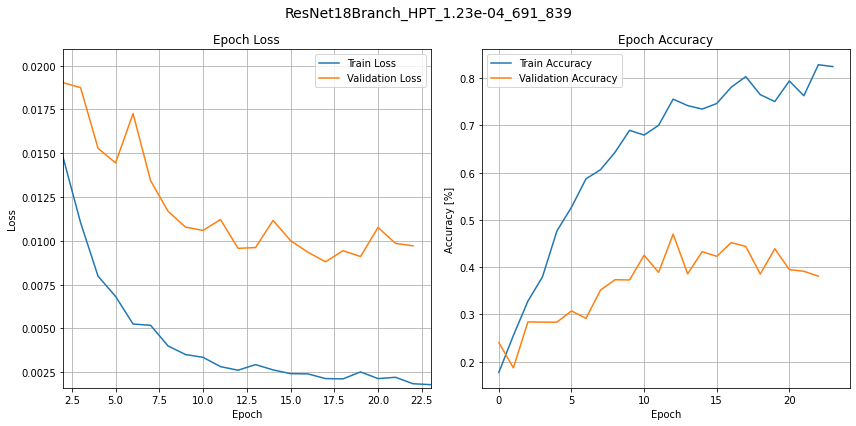



 Entrenamiento modelo: ResNet18Branch_HPT_1.02e-05_3798_878 


Epoch 1/25


Validation loss 0.02462: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0339 / 17.26% | Validation Loss / Accuracy: 0.0246 / 21.96%
Epoch 2/25


Validation loss 0.02400: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0268 / 19.95% | Validation Loss / Accuracy: 0.0240 / 21.79%
Epoch 3/25


Validation loss 0.02383: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0246 / 17.88% | Validation Loss / Accuracy: 0.0238 / 20.89%
Epoch 4/25


Validation loss 0.02475: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0230 / 22.88% | Validation Loss / Accuracy: 0.0248 / 17.19%
Epoch 5/25


Validation loss 0.02368: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0221 / 19.44% | Validation Loss / Accuracy: 0.0237 / 20.67%
Epoch 6/25


Validation loss 0.02417: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0210 / 22.41% | Validation Loss / Accuracy: 0.0242 / 18.97%
Epoch 7/25


Validation loss 0.02211: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0191 / 22.78% | Validation Loss / Accuracy: 0.0221 / 19.73%
Epoch 8/25


Validation loss 0.02421: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0181 / 27.75% | Validation Loss / Accuracy: 0.0242 / 18.44%
Epoch 9/25


Validation loss 0.02100: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0168 / 25.83% | Validation Loss / Accuracy: 0.0210 / 24.73%
Epoch 10/25


Validation loss 0.02155: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0149 / 27.49% | Validation Loss / Accuracy: 0.0215 / 21.12%
Epoch 11/25


Validation loss 0.02013: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0154 / 29.46% | Validation Loss / Accuracy: 0.0201 / 32.05%
Epoch 12/25


Validation loss 0.02638: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0137 / 32.74% | Validation Loss / Accuracy: 0.0264 / 23.93%
Epoch 13/25


Validation loss 0.02071: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0133 / 33.34% | Validation Loss / Accuracy: 0.0207 / 23.79%
Epoch 14/25


Validation loss 0.02126: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0129 / 30.49% | Validation Loss / Accuracy: 0.0213 / 20.94%
Epoch 15/25


Validation loss 0.02194: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0126 / 39.14% | Validation Loss / Accuracy: 0.0219 / 23.75%
Epoch 16/25


Validation loss 0.02128: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0114 / 38.01% | Validation Loss / Accuracy: 0.0213 / 21.56%
Epoch 17/25


Validation loss 0.01990: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0099 / 39.83% | Validation Loss / Accuracy: 0.0199 / 27.46%
Epoch 18/25


Validation loss 0.01986: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0104 / 41.36% | Validation Loss / Accuracy: 0.0199 / 24.60%
Epoch 19/25


Validation loss 0.02157: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0096 / 44.32% | Validation Loss / Accuracy: 0.0216 / 28.97%
Epoch 20/25


Validation loss 0.02158: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0087 / 44.74% | Validation Loss / Accuracy: 0.0216 / 23.97%
Epoch 21/25


Validation loss 0.02114: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0084 / 45.98% | Validation Loss / Accuracy: 0.0211 / 29.29%
Epoch 22/25


Validation loss 0.02100: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0079 / 48.88% | Validation Loss / Accuracy: 0.0210 / 29.82%
Epoch 23/25


Validation loss 0.01798: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0084 / 47.70% | Validation Loss / Accuracy: 0.0180 / 31.21%
Epoch 24/25


Validation loss 0.02022: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0082 / 50.34% | Validation Loss / Accuracy: 0.0202 / 21.29%
Epoch 25/25


Validation loss 0.02055: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0079 / 50.85% | Validation Loss / Accuracy: 0.0205 / 24.91%


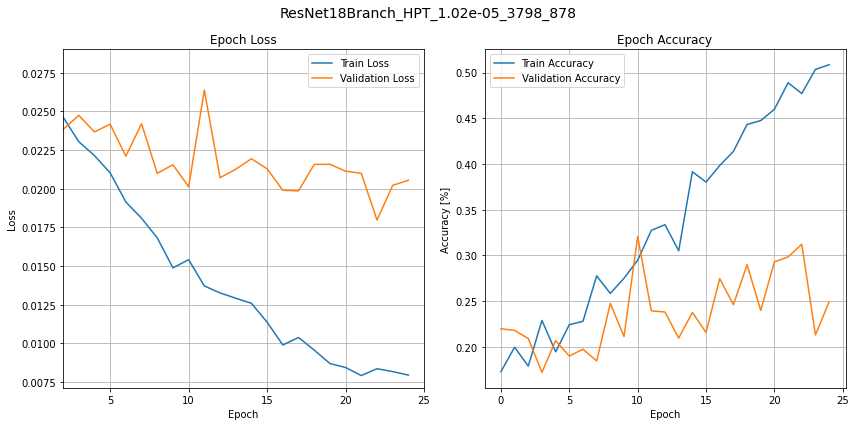



 Entrenamiento modelo: ResNet18Branch_HPT_7.94e-04_472_443 


Epoch 1/25


Validation loss 0.03026: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0809 / 10.69% | Validation Loss / Accuracy: 0.0303 / 18.35%
Epoch 2/25


Validation loss 0.02419: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0226 / 21.71% | Validation Loss / Accuracy: 0.0242 / 20.04%
Epoch 3/25


Validation loss 0.02161: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0195 / 29.57% | Validation Loss / Accuracy: 0.0216 / 21.16%
Epoch 4/25


Validation loss 0.02125: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0172 / 28.56% | Validation Loss / Accuracy: 0.0213 / 26.65%
Epoch 5/25


Validation loss 0.01868: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0142 / 30.93% | Validation Loss / Accuracy: 0.0187 / 28.97%
Epoch 6/25


Validation loss 0.01639: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0123 / 36.88% | Validation Loss / Accuracy: 0.0164 / 28.17%
Epoch 7/25


Validation loss 0.01722: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0100 / 41.01% | Validation Loss / Accuracy: 0.0172 / 29.11%
Epoch 8/25


Validation loss 0.01827: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0082 / 49.26% | Validation Loss / Accuracy: 0.0183 / 32.14%
Epoch 9/25


Validation loss 0.00845: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0062 / 54.15% | Validation Loss / Accuracy: 0.0084 / 49.87%
Epoch 10/25


Validation loss 0.00760: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0051 / 63.28% | Validation Loss / Accuracy: 0.0076 / 46.12%
Epoch 11/25


Validation loss 0.01179: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0038 / 70.37% | Validation Loss / Accuracy: 0.0118 / 45.22%
Epoch 12/25


Validation loss 0.01141: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0039 / 68.60% | Validation Loss / Accuracy: 0.0114 / 33.71%
Epoch 13/25


Validation loss 0.00633: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0039 / 71.15% | Validation Loss / Accuracy: 0.0063 / 54.87%
Epoch 14/25


Validation loss 0.00746: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0032 / 75.63% | Validation Loss / Accuracy: 0.0075 / 57.68%
Epoch 15/25


Validation loss 0.00784: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0028 / 76.68% | Validation Loss / Accuracy: 0.0078 / 49.06%
Epoch 16/25


Validation loss 0.00718: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0028 / 78.16% | Validation Loss / Accuracy: 0.0072 / 58.62%
Epoch 17/25


Validation loss 0.00579: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0024 / 79.64% | Validation Loss / Accuracy: 0.0058 / 55.00%
Epoch 18/25


Validation loss 0.00621: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0023 / 79.13% | Validation Loss / Accuracy: 0.0062 / 61.25%
Epoch 19/25


Validation loss 0.00751: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0017 / 86.29% | Validation Loss / Accuracy: 0.0075 / 39.33%
Epoch 20/25


Validation loss 0.00679: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0018 / 85.06% | Validation Loss / Accuracy: 0.0068 / 60.31%
Epoch 21/25


Validation loss 0.00565: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0024 / 78.63% | Validation Loss / Accuracy: 0.0057 / 56.74%
Epoch 22/25


Validation loss 0.00453: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0024 / 84.74% | Validation Loss / Accuracy: 0.0045 / 62.05%
Epoch 23/25


Validation loss 0.00501: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0026 / 82.99% | Validation Loss / Accuracy: 0.0050 / 61.79%
Epoch 24/25


Validation loss 0.00609: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0021 / 85.27% | Validation Loss / Accuracy: 0.0061 / 60.18%
Epoch 25/25


Validation loss 0.00545: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0017 / 84.57% | Validation Loss / Accuracy: 0.0055 / 60.98%


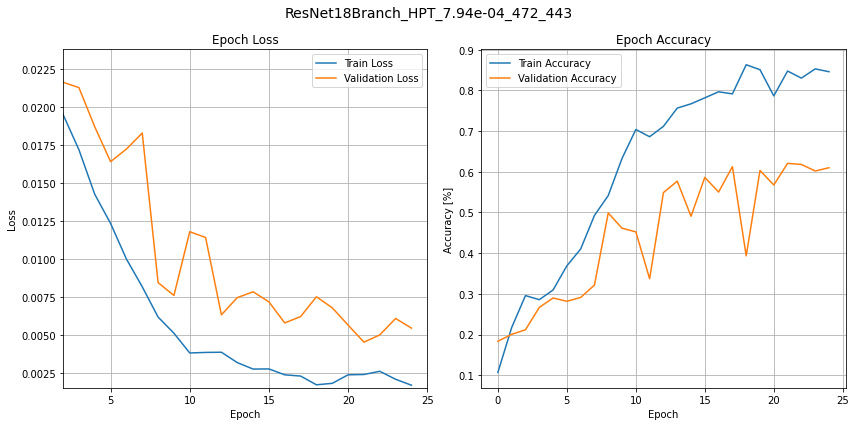



 Entrenamiento modelo: ResNet18Branch_HPT_7.04e-04_2326_315 


Epoch 1/25


Validation loss 0.03654: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.7036 / 12.95% | Validation Loss / Accuracy: 0.0365 / 14.24%
Epoch 2/25


Validation loss 0.03367: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0291 / 16.30% | Validation Loss / Accuracy: 0.0337 / 19.29%
Epoch 3/25


Validation loss 0.02204: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0244 / 16.11% | Validation Loss / Accuracy: 0.0220 / 22.28%
Epoch 4/25


Validation loss 0.02414: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0235 / 15.67% | Validation Loss / Accuracy: 0.0241 / 15.80%
Epoch 5/25


Validation loss 0.02153: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0225 / 18.54% | Validation Loss / Accuracy: 0.0215 / 21.34%
Epoch 6/25


Validation loss 0.02382: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0208 / 20.86% | Validation Loss / Accuracy: 0.0238 / 24.46%
Epoch 7/25


Validation loss 0.01886: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0195 / 24.14% | Validation Loss / Accuracy: 0.0189 / 26.21%
Epoch 8/25


Validation loss 0.01997: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0159 / 25.75% | Validation Loss / Accuracy: 0.0200 / 20.04%
Epoch 9/25


Validation loss 0.01852: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0133 / 34.95% | Validation Loss / Accuracy: 0.0185 / 24.78%
Epoch 10/25


Validation loss 0.01677: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0112 / 36.46% | Validation Loss / Accuracy: 0.0168 / 29.91%
Epoch 11/25


Validation loss 0.01687: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0094 / 42.47% | Validation Loss / Accuracy: 0.0169 / 32.95%
Epoch 12/25


Validation loss 0.01140: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0074 / 50.60% | Validation Loss / Accuracy: 0.0114 / 38.08%
Epoch 13/25


Validation loss 0.00894: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0058 / 52.55% | Validation Loss / Accuracy: 0.0089 / 41.96%
Epoch 14/25


Validation loss 0.00910: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0045 / 61.91% | Validation Loss / Accuracy: 0.0091 / 42.14%
Epoch 15/25


Validation loss 0.01086: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0038 / 66.26% | Validation Loss / Accuracy: 0.0109 / 36.52%
Epoch 16/25


Validation loss 0.01115: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0031 / 72.34% | Validation Loss / Accuracy: 0.0112 / 35.76%
Epoch 17/25


Validation loss 0.00772: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0029 / 73.61% | Validation Loss / Accuracy: 0.0077 / 53.12%
Epoch 18/25


Validation loss 0.00766: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0024 / 74.94% | Validation Loss / Accuracy: 0.0077 / 50.18%
Epoch 19/25


Validation loss 0.00875: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0022 / 77.68% | Validation Loss / Accuracy: 0.0087 / 44.33%
Epoch 20/25


Validation loss 0.00752: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0022 / 78.22% | Validation Loss / Accuracy: 0.0075 / 60.04%
Epoch 21/25


Validation loss 0.00817: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0019 / 81.86% | Validation Loss / Accuracy: 0.0082 / 45.40%
Epoch 22/25


Validation loss 0.00600: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0020 / 82.73% | Validation Loss / Accuracy: 0.0060 / 60.36%
Epoch 23/25


Validation loss 0.00693: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0017 / 82.89% | Validation Loss / Accuracy: 0.0069 / 56.12%
Epoch 24/25


Validation loss 0.00606: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0018 / 84.05% | Validation Loss / Accuracy: 0.0061 / 52.05%
Epoch 25/25


Validation loss 0.00580: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0017 / 82.40% | Validation Loss / Accuracy: 0.0058 / 56.92%


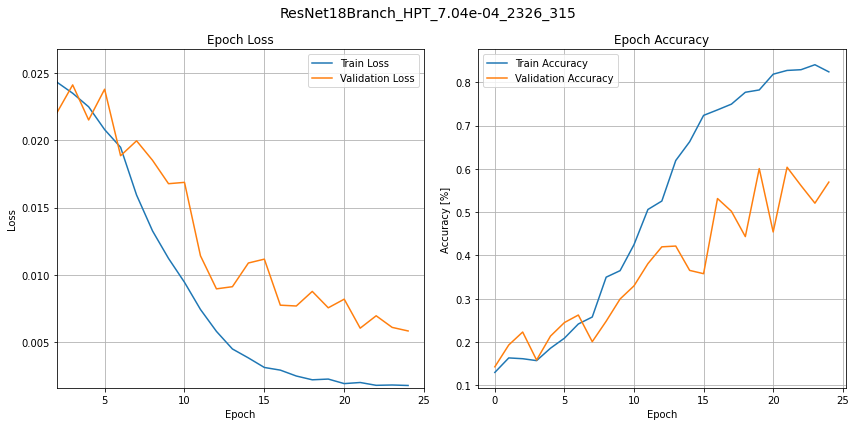



 Entrenamiento modelo: ResNet18Branch_HPT_1.24e-05_1579_683 


Epoch 1/25


Validation loss 0.03131: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0393 / 11.14% | Validation Loss / Accuracy: 0.0313 / 15.49%
Epoch 2/25


Validation loss 0.02372: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0291 / 16.82% | Validation Loss / Accuracy: 0.0237 / 16.29%
Epoch 3/25


Validation loss 0.02351: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0259 / 19.14% | Validation Loss / Accuracy: 0.0235 / 19.29%
Epoch 4/25


Validation loss 0.02303: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0223 / 17.59% | Validation Loss / Accuracy: 0.0230 / 22.59%
Epoch 5/25


Validation loss 0.02357: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0217 / 21.50% | Validation Loss / Accuracy: 0.0236 / 18.79%
Epoch 6/25


Validation loss 0.02370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0208 / 23.00% | Validation Loss / Accuracy: 0.0237 / 20.58%
Epoch 7/25


Validation loss 0.02087: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0197 / 21.07% | Validation Loss / Accuracy: 0.0209 / 19.73%
Epoch 8/25


Validation loss 0.02072: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0179 / 24.28% | Validation Loss / Accuracy: 0.0207 / 27.01%
Epoch 9/25


Validation loss 0.02105: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0182 / 23.10% | Validation Loss / Accuracy: 0.0211 / 22.59%
Epoch 10/25


Validation loss 0.01927: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0163 / 27.68% | Validation Loss / Accuracy: 0.0193 / 22.90%
Epoch 11/25


Validation loss 0.01991: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0154 / 27.68% | Validation Loss / Accuracy: 0.0199 / 18.79%
Epoch 12/25


Validation loss 0.02175: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0139 / 31.22% | Validation Loss / Accuracy: 0.0217 / 21.16%
Epoch 13/25


Validation loss 0.01939: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0132 / 36.04% | Validation Loss / Accuracy: 0.0194 / 27.14%
Epoch 14/25


Validation loss 0.01908: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0123 / 35.61% | Validation Loss / Accuracy: 0.0191 / 24.78%
Epoch 15/25


Validation loss 0.01933: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0121 / 38.15% | Validation Loss / Accuracy: 0.0193 / 29.78%
Epoch 16/25


Validation loss 0.01853: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0105 / 40.89% | Validation Loss / Accuracy: 0.0185 / 27.81%
Epoch 17/25


Validation loss 0.01765: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0101 / 41.89% | Validation Loss / Accuracy: 0.0177 / 28.53%
Epoch 18/25


Validation loss 0.01840: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0098 / 41.52% | Validation Loss / Accuracy: 0.0184 / 29.20%
Epoch 19/25


Validation loss 0.01904: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0094 / 43.68% | Validation Loss / Accuracy: 0.0190 / 24.60%
Epoch 20/25


Validation loss 0.01694: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0088 / 44.91% | Validation Loss / Accuracy: 0.0169 / 29.78%
Epoch 21/25


Validation loss 0.01931: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0080 / 45.17% | Validation Loss / Accuracy: 0.0193 / 33.26%
Epoch 22/25


Validation loss 0.01752: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0077 / 48.01% | Validation Loss / Accuracy: 0.0175 / 28.35%
Epoch 23/25


Validation loss 0.01688: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0071 / 52.40% | Validation Loss / Accuracy: 0.0169 / 28.71%
Epoch 24/25


Validation loss 0.01776: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0071 / 50.29% | Validation Loss / Accuracy: 0.0178 / 25.36%
Epoch 25/25


Validation loss 0.01734: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0071 / 50.19% | Validation Loss / Accuracy: 0.0173 / 28.84%


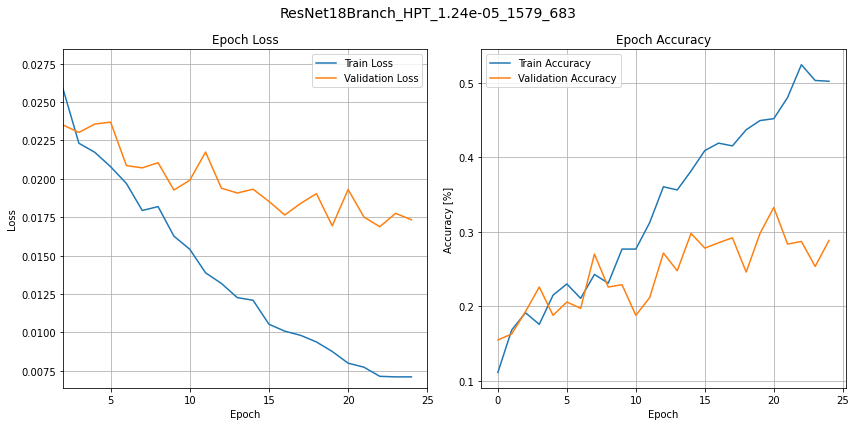



 Entrenamiento modelo: ResNet18Branch_HPT_3.60e-05_1870_866 


Epoch 1/25


Validation loss 0.03115: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0308 / 18.13% | Validation Loss / Accuracy: 0.0311 / 15.31%
Epoch 2/25


Validation loss 0.02590: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0238 / 22.60% | Validation Loss / Accuracy: 0.0259 / 21.47%
Epoch 3/25


Validation loss 0.02219: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0191 / 25.09% | Validation Loss / Accuracy: 0.0222 / 20.49%
Epoch 4/25


Validation loss 0.02252: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0158 / 31.20% | Validation Loss / Accuracy: 0.0225 / 23.35%
Epoch 5/25


Validation loss 0.02177: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0142 / 32.66% | Validation Loss / Accuracy: 0.0218 / 21.65%
Epoch 6/25


Validation loss 0.02032: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0118 / 37.89% | Validation Loss / Accuracy: 0.0203 / 32.14%
Epoch 7/25


Validation loss 0.01818: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0102 / 44.27% | Validation Loss / Accuracy: 0.0182 / 34.38%
Epoch 8/25


Validation loss 0.01605: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0082 / 44.13% | Validation Loss / Accuracy: 0.0161 / 35.58%
Epoch 9/25


Validation loss 0.01841: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0089 / 45.87% | Validation Loss / Accuracy: 0.0184 / 28.84%
Epoch 10/25


Validation loss 0.01862: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0074 / 47.70% | Validation Loss / Accuracy: 0.0186 / 37.95%
Epoch 11/25


Validation loss 0.01996: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0070 / 50.63% | Validation Loss / Accuracy: 0.0200 / 22.86%
Epoch 12/25


Validation loss 0.01652: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0066 / 53.71% | Validation Loss / Accuracy: 0.0165 / 35.76%
Epoch 13/25


Validation loss 0.01567: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0056 / 57.31% | Validation Loss / Accuracy: 0.0157 / 36.83%
Epoch 14/25


Validation loss 0.01581: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0055 / 56.18% | Validation Loss / Accuracy: 0.0158 / 34.15%
Epoch 15/25


Validation loss 0.01487: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0048 / 57.71% | Validation Loss / Accuracy: 0.0149 / 34.15%
Epoch 16/25


Validation loss 0.01243: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0038 / 65.17% | Validation Loss / Accuracy: 0.0124 / 34.20%
Epoch 17/25


Validation loss 0.01368: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0049 / 60.16% | Validation Loss / Accuracy: 0.0137 / 35.58%
Epoch 18/25


Validation loss 0.01328: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0038 / 65.70% | Validation Loss / Accuracy: 0.0133 / 42.37%
Epoch 19/25


Validation loss 0.01453: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0043 / 64.35% | Validation Loss / Accuracy: 0.0145 / 34.46%
Epoch 20/25


Validation loss 0.01325: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0039 / 65.30% | Validation Loss / Accuracy: 0.0132 / 39.20%
Epoch 21/25


Validation loss 0.01308: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0033 / 67.99% | Validation Loss / Accuracy: 0.0131 / 33.08%
Epoch 22/25


Validation loss 0.01358: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Se interrumpió el entrenamiento porque en los últimos 6 epochs no se logró menor loss que el mínimo (min:0.012429319228976965)


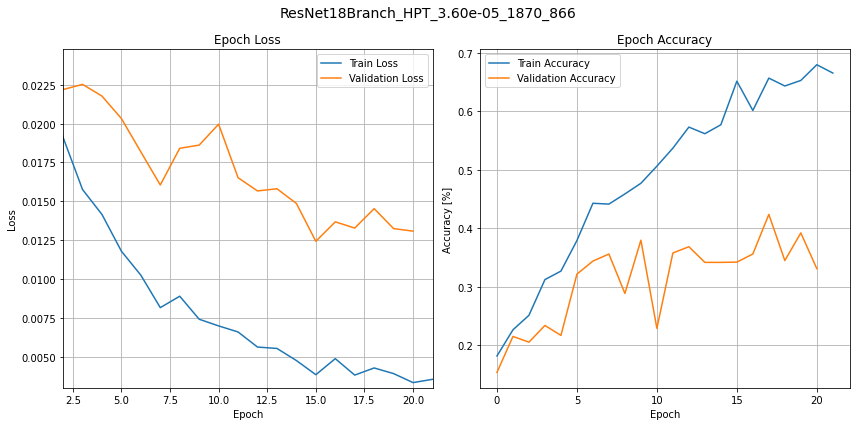



 Entrenamiento modelo: ResNet18Branch_HPT_6.26e-05_2404_394 


Epoch 1/25


Validation loss 0.02904: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0369 / 15.33% | Validation Loss / Accuracy: 0.0290 / 20.85%
Epoch 2/25


Validation loss 0.02188: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0222 / 22.79% | Validation Loss / Accuracy: 0.0219 / 23.53%
Epoch 3/25


Validation loss 0.02387: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0166 / 28.55% | Validation Loss / Accuracy: 0.0239 / 26.21%
Epoch 4/25


Validation loss 0.01891: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0130 / 34.83% | Validation Loss / Accuracy: 0.0189 / 24.24%
Epoch 5/25


Validation loss 0.01979: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0107 / 40.75% | Validation Loss / Accuracy: 0.0198 / 24.91%
Epoch 6/25


Validation loss 0.01562: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0098 / 42.67% | Validation Loss / Accuracy: 0.0156 / 28.39%
Epoch 7/25


Validation loss 0.01627: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0089 / 43.17% | Validation Loss / Accuracy: 0.0163 / 30.58%
Epoch 8/25


Validation loss 0.01687: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0065 / 54.43% | Validation Loss / Accuracy: 0.0169 / 28.79%
Epoch 9/25


Validation loss 0.01604: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0056 / 58.07% | Validation Loss / Accuracy: 0.0160 / 32.32%
Epoch 10/25


Validation loss 0.01587: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0051 / 57.05% | Validation Loss / Accuracy: 0.0159 / 28.35%
Epoch 11/25


Validation loss 0.01474: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0052 / 59.08% | Validation Loss / Accuracy: 0.0147 / 31.16%
Epoch 12/25


Validation loss 0.01435: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0044 / 61.52% | Validation Loss / Accuracy: 0.0144 / 32.14%
Epoch 13/25


Validation loss 0.01461: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0043 / 61.48% | Validation Loss / Accuracy: 0.0146 / 27.72%
Epoch 14/25


Validation loss 0.01375: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0043 / 62.36% | Validation Loss / Accuracy: 0.0138 / 30.58%
Epoch 15/25


Validation loss 0.01412: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0042 / 63.21% | Validation Loss / Accuracy: 0.0141 / 33.88%
Epoch 16/25


Validation loss 0.01459: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0034 / 68.58% | Validation Loss / Accuracy: 0.0146 / 28.93%
Epoch 17/25


Validation loss 0.01518: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0030 / 70.17% | Validation Loss / Accuracy: 0.0152 / 33.13%
Epoch 18/25


Validation loss 0.01287: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0034 / 70.70% | Validation Loss / Accuracy: 0.0129 / 36.70%
Epoch 19/25


Validation loss 0.01200: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0027 / 74.71% | Validation Loss / Accuracy: 0.0120 / 33.88%
Epoch 20/25


Validation loss 0.01267: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0031 / 71.87% | Validation Loss / Accuracy: 0.0127 / 35.45%
Epoch 21/25


Validation loss 0.01272: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0034 / 68.72% | Validation Loss / Accuracy: 0.0127 / 29.42%
Epoch 22/25


Validation loss 0.01215: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0030 / 71.38% | Validation Loss / Accuracy: 0.0122 / 41.56%
Epoch 23/25


Validation loss 0.01158: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0036 / 68.63% | Validation Loss / Accuracy: 0.0116 / 34.38%
Epoch 24/25


Validation loss 0.01179: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0030 / 70.84% | Validation Loss / Accuracy: 0.0118 / 35.58%
Epoch 25/25


Validation loss 0.01112: 100%|███████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.44s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0028 / 74.16% | Validation Loss / Accuracy: 0.0111 / 36.65%


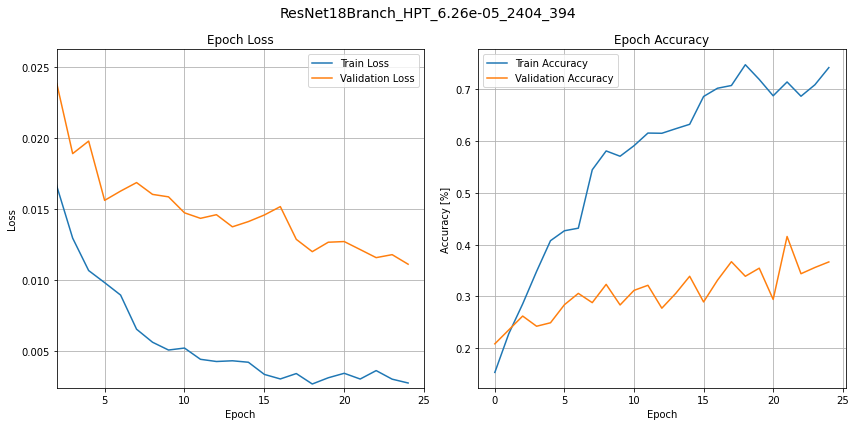

In [ ]:

for hyperparam in hyperparams:
    
    name = f"MobileNetV2_HPT__lr_{hyperparam['lr']:.2e}__lastfc_{hyperparam['n_last_fc']}__branchfc_{hyperparam['n_brach_fc']}"
    
    modelHPTuning = GazeEstimation_ResNet18Branch(name=name, trainable=True, n_last_fc=hyperparam['n_last_fc'], n_brach_fc=hyperparam['n_brach_fc'])

    # Seteamos un early stop
    modelHPTuning.early_stop = True
    modelHPTuning.not_minimum_count = 5

    # Al ser un problema de regresión se usa MSELoss
    criterion = nn.MSELoss()

    # Optimizador: Adam
    optimizer = torch.optim.Adam(modelHPTuning.parameters(), lr=hyperparam['lr'])

    # Entrenamiento
    print(f"\n\n Entrenamiento modelo: {name} \n\n")
    modelHPTuning.fit(train_loader, val_loader, criterion, optimizer, epochs=25, device=device, save_model=True)

    plot_metrics(modelHPTuning, title=name)
    